In [1]:
from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
import telegram
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.simplefilter('ignore')   
import pandas as pd
import datetime as dt
from datetime import date, datetime, timedelta
import pandahouse
import sys
import os
from scipy import stats
import hashlib
connection = {
       'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20220820.feed_actions'}
def select(sql):
    data = pandahouse.read_clickhouse(sql, connection=connection)
    return data

# Дефолтные параметры, которые прокидываются в таски
default_args = {
        'owner': 'a-mershevoj-10', 
        'depends_on_past': False,  
        'retries': 2,
        'retry_delay': timedelta(minutes=5),
        'start_date': datetime(2022, 9, 1),}
    # время запуска
schedule_interval = '0 11 * * *'  

chat_id = 799366541#-555114317 # номер нашего чата что бы работало нужно что бы группа добавила бота а пользователь начал с ним общения
my_token = '5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI' # Никому не говорить - доступ к боду, выдается когда создается бот
bot= telegram.Bot(token=my_token)
updates = bot.getUpdates()
chat = chat_id or 799366541
bot= telegram.Bot(token='5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI')

# Знакомство с сервисом - построение дашборда

На самом начальном этапе работы с новым проектом, аналитика должна отвечать на главный вопрос - "сколько?"
- сколько у нас пользователей в день? в неделю? месяц?
- сколько лайков? просмотров?
- и т.д.


Первое, что мы сделали с помощью SUPERSET разработли дашборды, на которых визуализированы основные метрики (в т.ч. лайки, просмотры, CTR, ретеншн, отток пользователей и когорты):

1. https://superset.lab.karpov.courses/superset/dashboard/1525/?preselect_filters=%7B%2210888%22%3A%7B%22__time_range%22%3A%22No+filter%22%7D%7D&native_filters=%28%29
2. https://superset.lab.karpov.courses/superset/dashboard/1532/?preselect_filters=%7B%7D&native_filters=%28%29

### Лента новостей - основное

In [2]:
#расчет DAU
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY 
         toStartOfDay(toDateTime(time))
'''
dau = select(sql)
print('вид таблицы DAU:')
display(dau.head())

вид таблицы DAU:


,date,num_users
0,2022-06-20,4917
1,2022-07-09,12478
2,2022-08-27,18742
3,2022-06-17,2325
4,2022-09-18,19931


In [3]:
#расчет WAU
sql = '''SELECT toStartOfWeek(time,1) AS date,
       
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY 
         toStartOfWeek(time,1)
'''
wau = select(sql)
print('вид таблицы WAU:')
display(wau.head())

вид таблицы WAU:


,date,num_users
0,2022-06-13,6881
1,2022-06-20,19566
2,2022-06-27,30898
3,2022-07-04,40341
4,2022-07-11,48125


In [4]:
#расчет MAU
sql = '''SELECT toStartOfMonth(time) AS date,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY 
         toStartOfMonth(time)
'''
mau = select(sql)
print('вид таблицы MAU:')
display(mau.head())

вид таблицы MAU:


,date,num_users
0,2022-06-01,26993
1,2022-07-01,92367
2,2022-08-01,132517
3,2022-09-01,145198


In [5]:
#расчет CTR в разрезе 
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
        countIf(user_id,action='view') AS views,
        countIf(user_id,action='like') AS likes,
        round(likes/views,3) as ctr
FROM simulator_20220820.feed_actions
GROUP BY 
         toStartOfDay(toDateTime(time))
'''
ctr = select(sql)
print('вид таблицы CTR:')
display(ctr.head())

вид таблицы CTR:


,date,views,likes,ctr
0,2022-08-14,522682,100663,0.193
1,2022-08-20,589754,120339,0.204
2,2022-08-30,617487,124494,0.202
3,2022-08-23,650507,137902,0.212
4,2022-09-17,828869,186906,0.225


In [6]:
#коэфициент прилипания / Stickiness (DAU/MAU).
sql = '''SELECT toStartOfDay(toDateTime(day)) AS date,
       round(AVG(t)*100, 1) AS "Stickiness"
FROM
  (SELECT toStartOfDay(toDateTime(time)) AS day,
          count(DISTINCT user_id) /
     (SELECT count(DISTINCT user_id)
      FROM simulator_20220820.feed_actions
      WHERE month(time) = month(now())) AS t
   FROM simulator_20220820.feed_actions
   WHERE month(time) = month(now())
   GROUP BY toStartOfDay(toDateTime(time))
   ORDER BY day) AS virtual_table
GROUP BY toStartOfDay(toDateTime(day))
ORDER BY "Stickiness" DESC'''
Stickiness = select(sql)
print('вид таблицы Stickiness (DAU/MAU):')
display(Stickiness.head())

вид таблицы Stickiness (DAU/MAU):


,date,Stickiness


In [7]:
#количество пользователей на 1 пост
sql = '''SELECT toDate(time) as date,
                  count(distinct post_id) as posts,
                  count(distinct user_id) as users,
                  round(users/posts,3) as average_users
           FROM simulator_20220820.feed_actions
           group by toDate(time)
'''
avg_users_per_post = select(sql)
print('вид таблицы среднее количество пользователей на 1 пост:')
display(avg_users_per_post.head())

вид таблицы среднее количество пользователей на 1 пост:


,date,posts,users,average_users
0,2022-06-16,87,1198,13.770
1,2022-06-17,150,2325,15.500
2,2022-06-18,168,3388,20.167
3,2022-06-19,193,4121,21.352
4,2022-06-20,168,4917,29.268


In [8]:
#количество событий на 1 пользователя
sql = '''SELECT toDate(time) as date,
                  count(post_id) as events,
                  count(distinct user_id) as users,
                  round(events/users,3) as average_events
           FROM simulator_20220820.feed_actions
           group by toDate(time)
'''
avg_events_per_user = select(sql)
print('вид таблицы среднее количество событий на 1 пользователя:')
display(avg_events_per_user.head())

вид таблицы среднее количество событий на 1 пользователя:


,date,events,users,average_events
0,2022-06-16,10088,1198,8.421
1,2022-06-17,74211,2325,31.919
2,2022-06-18,152226,3388,44.931
3,2022-06-19,183014,4121,44.410
4,2022-06-20,216758,4917,44.083


Text(0.5, 1.0, 'Average events per user')

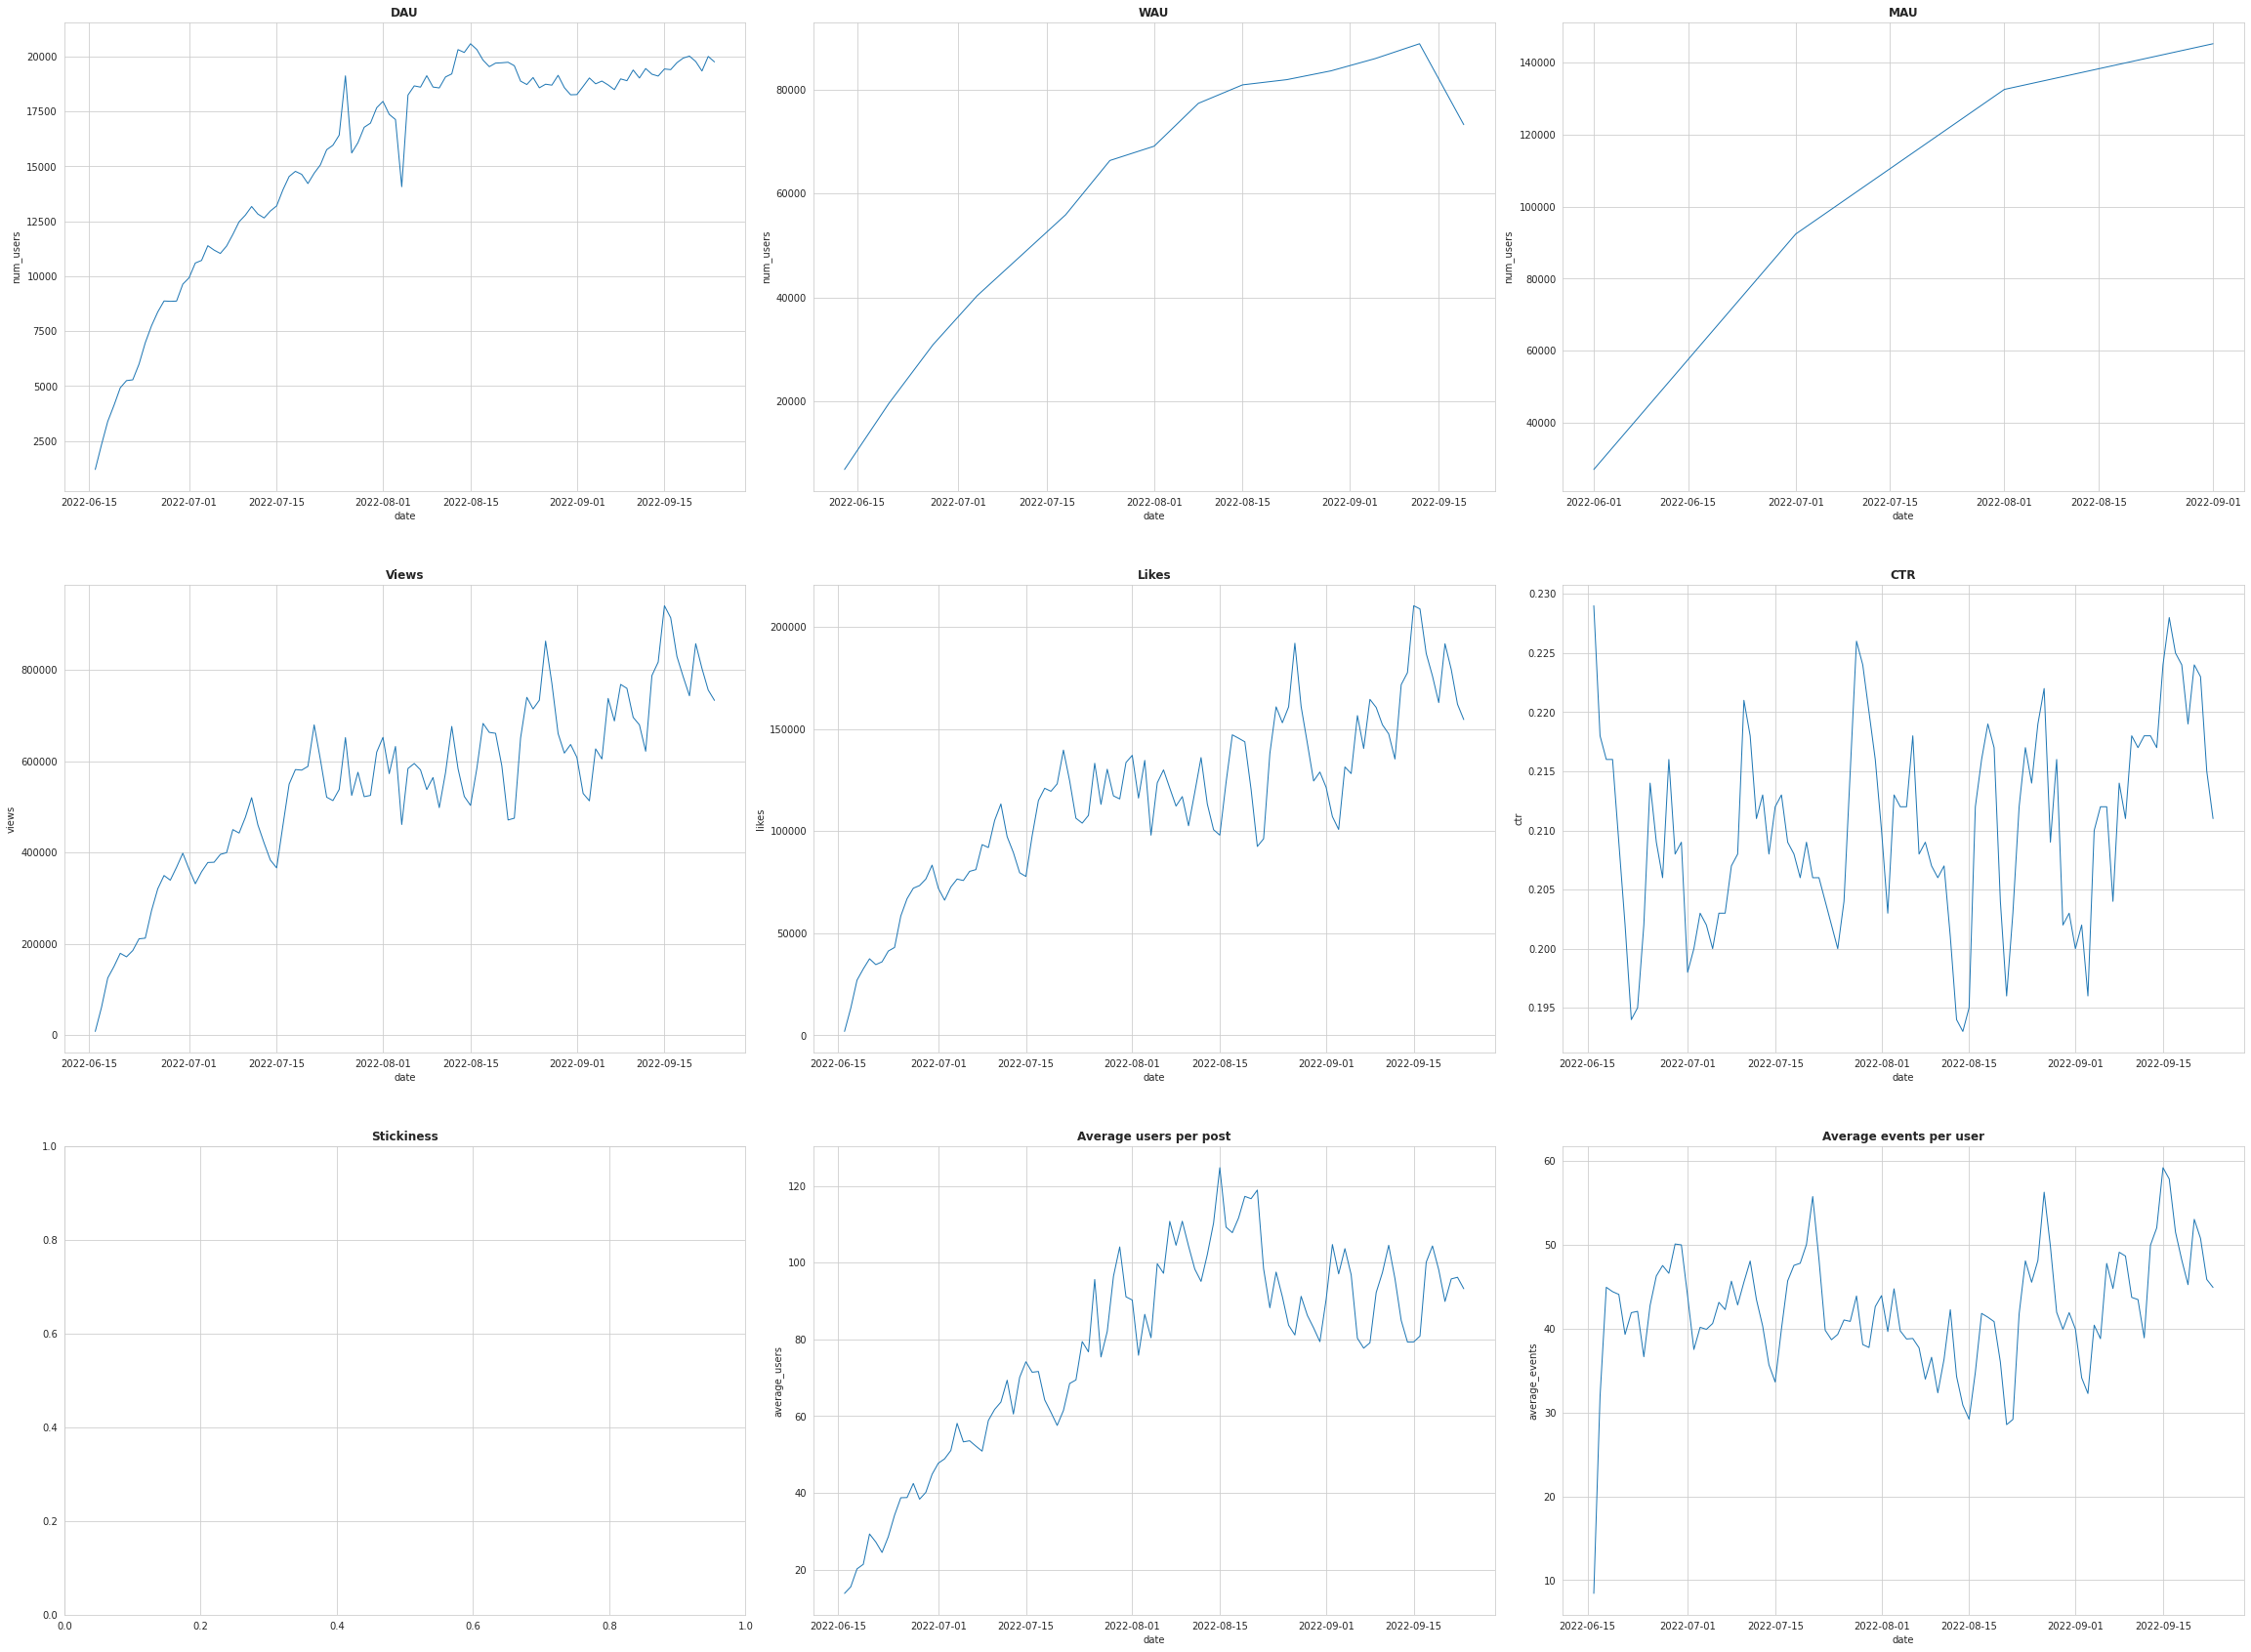

In [9]:
# построение графиков DAU/WAU/MAU/Views/Likes/CTR
fig, axes = plt.subplots(3, 3,  figsize=(40,30))
# plt.rcParams['axes.facecolor'] = 'white'
fig.subplots_adjust(hspace=0.2)  # развинем графики
fig.subplots_adjust(wspace=0.1)
# ГРАФИК DAU
sns.lineplot(ax=axes[0, 0], data=dau, x='date', y='num_users', palette="tab10", linewidth=1)
axes[0, 0].set_title('DAU', fontsize=12, fontweight="bold")
# ГРАФИК WAU
sns.lineplot(ax=axes[0, 1], data=wau, x='date', y='num_users', palette="tab10", linewidth=1)
axes[0, 1].set_title('WAU', fontsize=12, fontweight="bold")
# ГРАФИК MAU
sns.lineplot(ax=axes[0, 2], data=mau, x='date', y='num_users', palette="tab10", linewidth=1)
axes[0, 2].set_title('MAU', fontsize=12, fontweight="bold")
# ГРАФИК views
sns.lineplot(ax=axes[1, 0], data=ctr, x='date', y='views', palette="tab10", linewidth=1)
axes[1, 0].set_title('Views', fontsize=12, fontweight="bold")
# ГРАФИК likes
sns.lineplot(ax=axes[1, 1], data=ctr, x='date', y='likes', palette="tab10", linewidth=1)
axes[1, 1].set_title('Likes', fontsize=12, fontweight="bold")
# ГРАФИК CTR
sns.lineplot(ax=axes[1, 2], data=ctr, x='date', y='ctr',  palette="tab10", linewidth=1)
axes[1, 2].set_title('CTR', fontsize=12, fontweight="bold")
# ГРАФИК Stickiness
sns.lineplot(ax=axes[2, 0], data=Stickiness, x='date', y='Stickiness', palette="tab10", linewidth=1)
axes[2, 0].set_title('Stickiness', fontsize=12, fontweight="bold")
# ГРАФИК среднее количество пользователей на 1 пост
sns.lineplot(ax=axes[2, 1], data=avg_users_per_post, x='date', y='average_users', palette="tab10", linewidth=1)
axes[2, 1].set_title('Average users per post', fontsize=12, fontweight="bold")
# ГРАФИК среднее количество событий на 1 пользователя
sns.lineplot(ax=axes[2, 2], data=avg_events_per_user, x='date', y='average_events', palette="tab10", linewidth=1)
axes[2, 2].set_title('Average events per user', fontsize=12, fontweight="bold")

# АНАЛИЗ ПРОДУКТОВЫХ МЕТРИК

## Поведение пользователей ленты новостей в зависимости от трафика

В наших данных использования ленты новостей есть два типа юзеров: т.е., кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'.

Проанализируем и сравниим Retention этих двух групп пользователей и определим отличается ли характер использования приложения у этих групп пользователей. 


С помощью SUPERSET разработаем дашборд, на котором визуализируем основные метрики и сравним характер поведения.

1. https://superset.lab.karpov.courses/superset/dashboard/1623/?preselect_filters=%7B%7D&native_filters=%28%29

In [10]:
#расчет DAU
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
       source AS source,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfDay(toDateTime(time))
ORDER BY source'''
dau = select(sql)
print('вид таблицы DAU:')
display(dau.head())

вид таблицы DAU:


,date,source,num_users
0,2022-06-23,ads,2719
1,2022-06-24,ads,3259
2,2022-09-06,ads,9887
3,2022-08-27,ads,9209
4,2022-08-18,ads,8123


In [11]:
#расчет WAU
sql = '''SELECT toStartOfWeek(time,1) AS date,
       source AS source,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfWeek(time,1)
ORDER BY source'''
wau = select(sql)
print('вид таблицы WAU:')
display(wau.head())

вид таблицы WAU:


,date,source,num_users
0,2022-06-13,ads,3442
1,2022-08-29,ads,43300
2,2022-06-20,ads,9581
3,2022-07-11,ads,22766
4,2022-08-01,ads,30433


In [12]:
#расчет MAU
sql = '''SELECT toStartOfMonth(time) AS date,
       source AS source,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfMonth(time)
ORDER BY source'''
mau = select(sql)
print('вид таблицы MAU:')
display(mau.head())

вид таблицы MAU:


,date,source,num_users
0,2022-06-01,ads,13491
1,2022-08-01,ads,71858
2,2022-07-01,ads,47692
3,2022-09-01,ads,86617
4,2022-06-01,organic,13502


In [13]:
#расчет CTR в разрезе 
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
        source AS source,
        countIf(user_id,action='view') AS views,
        countIf(user_id,action='like') AS likes,
        round(likes/views,3) as ctr
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfDay(toDateTime(time))
ORDER BY source'''
ctr = select(sql)
print('вид таблицы CTR:')
display(ctr.head())

вид таблицы CTR:


,date,source,views,likes,ctr
0,2022-07-24,ads,219713,44678,0.203
1,2022-09-08,ads,406502,86953,0.214
2,2022-07-12,ads,204234,43626,0.214
3,2022-06-16,ads,4694,1058,0.225
4,2022-06-23,ads,95755,18870,0.197


In [14]:
#коэфициент прилипания / Stickiness (DAU/MAU).
sql = '''SELECT toStartOfDay(toDateTime(day)) AS date,
        source,
       round(AVG(t)*100, 1) AS "Stickiness"
FROM
  (SELECT toStartOfDay(toDateTime(time)) AS day,
          source,
          count(DISTINCT user_id) /
     (SELECT count(DISTINCT user_id)
      FROM simulator_20220820.feed_actions
      WHERE month(time) = month(now())) AS t
   FROM simulator_20220820.feed_actions
   WHERE month(time) = month(now())
   GROUP BY toStartOfDay(toDateTime(time)), source
   ORDER BY day) AS virtual_table
GROUP BY toStartOfDay(toDateTime(day)), source
ORDER BY "Stickiness" DESC'''
Stickiness = select(sql)
print('вид таблицы Stickiness (DAU/MAU):')
display(Stickiness.head())

вид таблицы Stickiness (DAU/MAU):


,date,source,Stickiness


In [15]:
#количество пользователей на 1 пост
sql = '''SELECT toDate(time) as date, source, 
                  count(distinct post_id) as posts,
                  count(distinct user_id) as users,
                  round(users/posts,3) as average_users
           FROM simulator_20220820.feed_actions
           group by toDate(time), source
'''
avg_users_per_post = select(sql)
print('вид таблицы среднее количество пользователей на 1 пост:')
display(avg_users_per_post.head())

вид таблицы среднее количество пользователей на 1 пост:


,date,source,posts,users,average_users
0,2022-07-23,organic,227,8910,39.251
1,2022-07-02,ads,217,4677,21.553
2,2022-09-15,organic,245,8945,36.510
3,2022-08-21,organic,166,10584,63.759
4,2022-06-16,organic,83,528,6.361


In [16]:
#количество событий на 1 пользователя
sql = '''SELECT toDate(time) as date, source, 
                  count(post_id) as events,
                  count(distinct user_id) as users,
                  round(events/users,3) as average_events
           FROM simulator_20220820.feed_actions
           group by toDate(time), source
'''
avg_events_per_user = select(sql)
print('вид таблицы среднее количество событий на 1 пользователя:')
display(avg_events_per_user.head())

вид таблицы среднее количество событий на 1 пользователя:


,date,source,events,users,average_events
0,2022-07-23,organic,356786,8910,40.043
1,2022-07-02,ads,176599,4677,37.759
2,2022-09-15,organic,528010,8945,59.029
3,2022-08-21,organic,302133,10584,28.546
4,2022-06-16,organic,4336,528,8.212


In [17]:
sql = '''
SELECT toStartOfDay(toDateTime(date)) AS __timestamp,
       source AS source,
                 AVG(rr) AS "AVG(rr)"
FROM
  (SELECT *
   FROM
     (SELECT *,
             num_users/start_users as rr,
             row_number() over (partition by source,
                                             start_date
                                order by date) as n,
                               count(*) over (partition by source,
                                                           start_date) as ltv
      FROM
        (SELECT *,
                FIRST_VALUE(num_users) over (partition by source,
                                                          start_date
                                             order by date) as start_users
         FROM
           (SELECT source,
                   start_date,date, COUNT(user_id) as num_users
            FROM
              (SELECT *,
                      min(date) over (PARTITION BY user_id
                                      ORDER BY date) as start_date
               FROM
                 (SELECT source,
                         toDate(time) as date,
                         user_id
                  FROM simulator_20220820.feed_actions
                  GROUP BY source,
                           toDate(time),
                           user_id) as t1) as t2
            GROUP BY source,
                     start_date,date) as t3) as t4) as t5
   where n between 1 and 22
   order BY source,
            start_date,
            n) AS virtual_table
GROUP BY source,
         toStartOfDay(toDateTime(date))
ORDER BY "AVG(rr)" DESC
'''
rr = select(sql)
rr.columns = ['date','source','average_RR']
print('вид таблицы средний RR когорт за последние 21 день:')
display(rr.head())

вид таблицы средний RR когорт за последние 21 день:


,date,source,average_RR
0,2022-06-16,ads,1.000000
1,2022-06-16,organic,1.000000
2,2022-06-17,organic,0.726326
3,2022-06-17,ads,0.701493
4,2022-06-18,organic,0.649352


In [18]:
sql = '''SELECT toStartOfDay(toDateTime(time)) AS __timestamp,
       countIf(DISTINCT user_id, source = 'ads')/countIf(DISTINCT user_id, source = 'organic') AS "ads_users / organic/users"
FROM simulator_20220820.feed_actions
GROUP BY toStartOfDay(toDateTime(time))
ORDER BY "ads_users / organic/users" DESC
'''
ads_organic = select(sql)
ads_organic.columns = ['date', 'ratio']
print('вид таблицы отношение рекламных пользователей к органическим:')
display(ads_organic.head())

вид таблицы отношение рекламных пользователей к органическим:


,date,ratio
0,2022-09-19,1.275890
1,2022-06-16,1.268939
2,2022-09-17,1.266897
3,2022-09-22,1.255977
4,2022-09-20,1.248437


In [19]:
sql = '''SELECT toStartOfDay(toDateTime(time)) AS __timestamp,
       source AS source,
                 AVG(num_posts) AS "AVG(num_posts)"
FROM
  (SELECT source,
          time,
          count(distinct post_id) as num_posts
   FROM simulator_20220820.feed_actions
   GROUP BY source,
            time) AS virtual_table
GROUP BY source,
         toStartOfDay(toDateTime(time))
ORDER BY "AVG(num_posts)" DESC
'''
avg_posts = select(sql)
avg_posts.columns = ['date', 'source', 'average_posts']
print('вид таблицы среднее количество постов в день:')
display(avg_posts.head())

вид таблицы среднее количество постов в день:


,date,source,average_posts
0,2022-09-15,ads,6.938360
1,2022-09-16,ads,6.816087
2,2022-09-20,ads,6.483415
3,2022-09-17,ads,6.300377
4,2022-09-14,ads,6.070147


Text(0.5, 1.0, 'Avarage numbers posts for day')

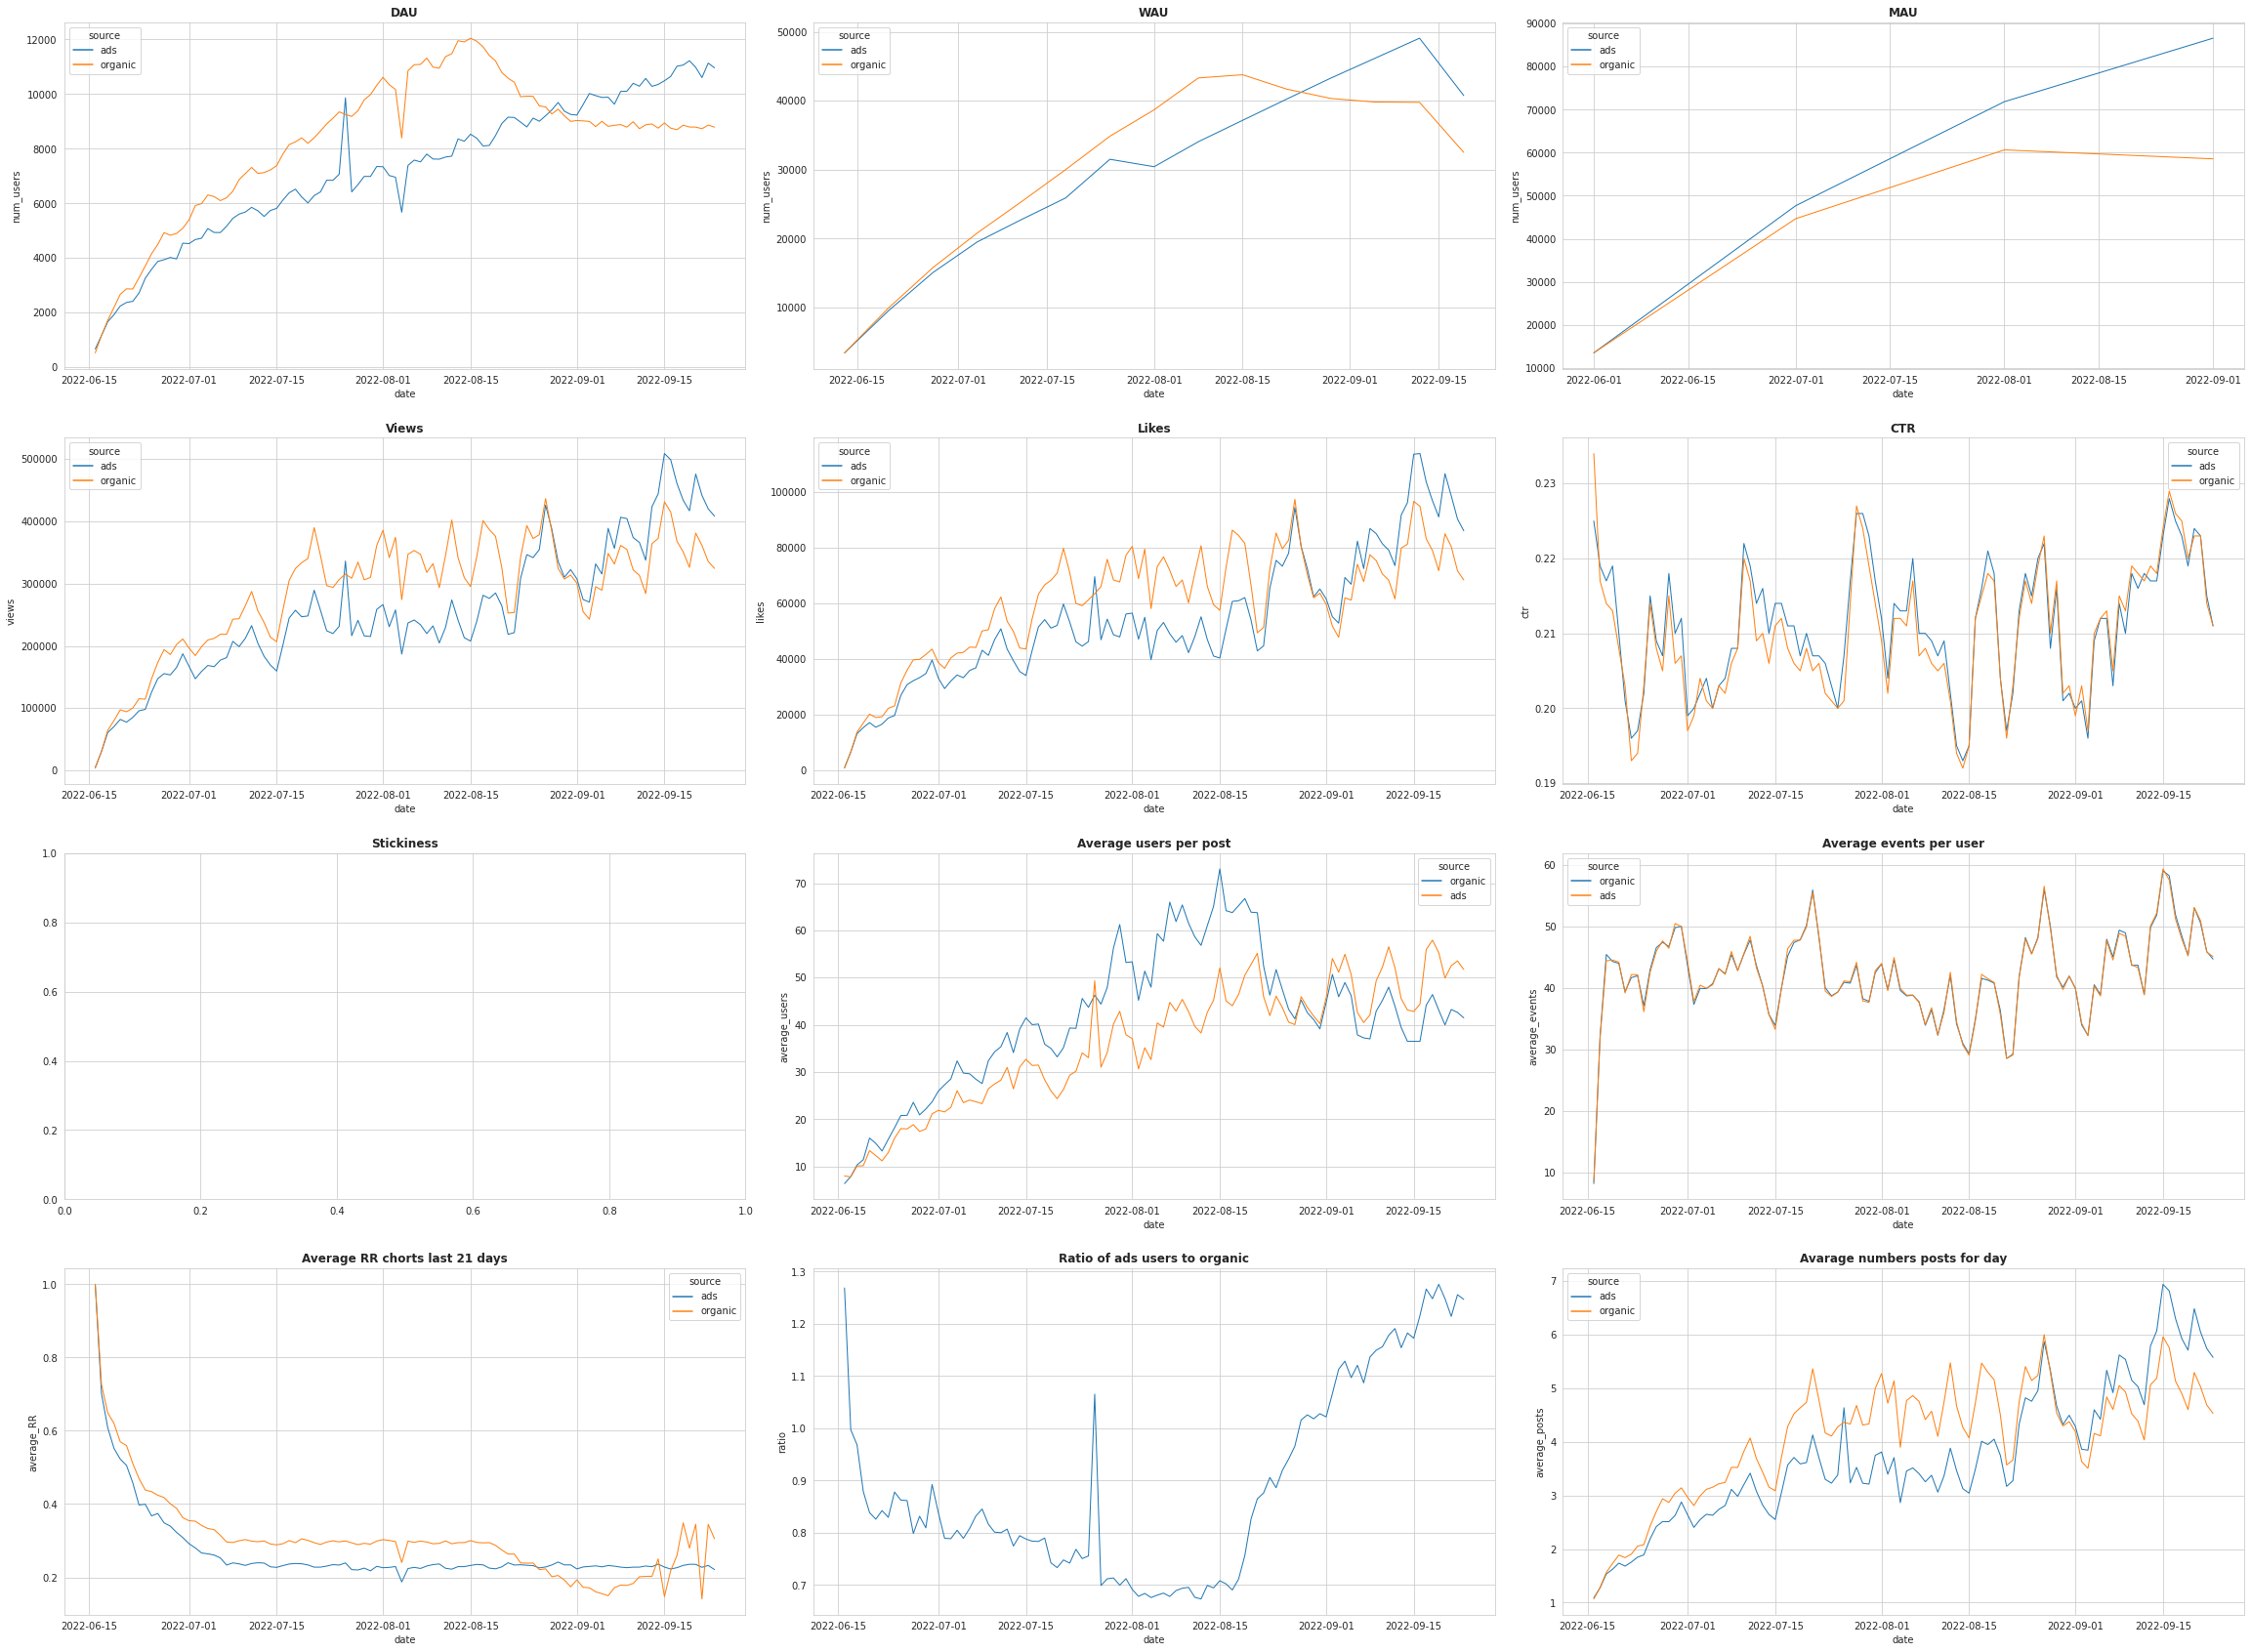

In [20]:
# построение графиков DAU/WAU/MAU/Views/Likes/CTR
fig, axes = plt.subplots(4, 3,  figsize=(40,30))
# plt.rcParams['axes.facecolor'] = 'white'
fig.subplots_adjust(hspace=0.2)  # развинем графики
fig.subplots_adjust(wspace=0.1)
# ГРАФИК DAU
sns.lineplot(ax=axes[0, 0], data=dau, x='date', y='num_users', hue='source',palette="tab10", linewidth=1)
axes[0, 0].set_title('DAU', fontsize=12, fontweight="bold")
# ГРАФИК WAU
sns.lineplot(ax=axes[0, 1], data=wau, x='date', y='num_users', hue='source',palette="tab10", linewidth=1)
axes[0, 1].set_title('WAU', fontsize=12, fontweight="bold")
# ГРАФИК MAU
sns.lineplot(ax=axes[0, 2], data=mau, x='date', y='num_users', hue='source',palette="tab10", linewidth=1)
axes[0, 2].set_title('MAU', fontsize=12, fontweight="bold")
# ГРАФИК views
sns.lineplot(ax=axes[1, 0], data=ctr, x='date', y='views', hue='source',palette="tab10", linewidth=1)
axes[1, 0].set_title('Views', fontsize=12, fontweight="bold")
# ГРАФИК likes
sns.lineplot(ax=axes[1, 1], data=ctr, x='date', y='likes', hue='source',palette="tab10", linewidth=1)
axes[1, 1].set_title('Likes', fontsize=12, fontweight="bold")
# ГРАФИК CTR
sns.lineplot(ax=axes[1, 2], data=ctr, x='date', y='ctr', hue='source',palette="tab10", linewidth=1)
axes[1, 2].set_title('CTR', fontsize=12, fontweight="bold")
# ГРАФИК Stickiness
sns.lineplot(ax=axes[2, 0], data=Stickiness, x='date', y='Stickiness', hue='source', palette="tab10", linewidth=1)
axes[2, 0].set_title('Stickiness', fontsize=12, fontweight="bold")
# ГРАФИК среднее количество пользователей на 1 пост
sns.lineplot(ax=axes[2, 1], data=avg_users_per_post, x='date', y='average_users', hue='source',palette="tab10", linewidth=1)
axes[2, 1].set_title('Average users per post', fontsize=12, fontweight="bold")
# ГРАФИК среднее количество событий на 1 пользователя
sns.lineplot(ax=axes[2, 2], data=avg_events_per_user, x='date', y='average_events', hue='source', palette="tab10", linewidth=1)
axes[2, 2].set_title('Average events per user', fontsize=12, fontweight="bold")
# ГРАФИК Retantion Rate когорт за последние 21 день
sns.lineplot(ax=axes[3, 0], data=rr, x='date', y='average_RR', hue='source', palette="tab10", linewidth=1)
axes[3, 0].set_title('Average RR chorts last 21 days', fontsize=12, fontweight="bold")
# ГРАФИК отношения пользоватейлей пришедших в результате рекламы к органическим
sns.lineplot(ax=axes[3, 1], data=ads_organic, x='date', y='ratio', palette="tab10", linewidth=1)
axes[3, 1].set_title('Ratio of ads users to organic', fontsize=12, fontweight="bold")
# ГРАФИК  среднее количество постов в день
sns.lineplot(ax=axes[3, 2], data=avg_posts, x='date', y='average_posts', hue='source',palette="tab10", linewidth=1)
axes[3, 2].set_title('Avarage numbers posts for day', fontsize=12, fontweight="bold")

**ВЫВОДЫ**

Характер использования приложения у органических пользователей и пользователей пришедших из платного трафика не имеют сильных различий можно сказать, что они не различаются до 18.08.2022, так как начиная с этой даты удержание значительно меняется и ads пользователи пришедшие с 18.08.2022 имеют удержание выше, чем органические, что может говорить нам о том, что что-то изменилось в поведении пользователей в связи с чем изменился их характер использования. Дополнительная информация:

- Количество пользователей пришедших через платный трафик стабильно меньше, чем органических, при этом отношения количества ads пользователей к органическим пользователям снижается постоянно, а начиная с 18.08.2022 значительно возрастает.
- 26.07.2022 был значительный скачок платных потребителей, но это не повлияло на их количество в дальнейшем т.е. увеличение количества ads потребителей возрастет с плавно.
- 04.08.2022 у всех пользователей заметен провал взаимодействия с сервисом;
- RR до 18.08.2022 года стабильно выше у органических пользователей, при этом у когорт присоединившихся к сервису с 18.08.2022 и позднее заметны изменения в удержании, а именно органические пользователи теряют лояльность к сервису и их RR снижается и уже имеет показатель ниже чем у ads который начинает расти.

## Анализ "качества" пользователей пришедших в результате рекламной компании *26.07.2022

Маркетологи запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей, виден всплеск на графике активной аудитории за 26.07.2022.

Однако у нас есть сомнение в качестве трафика, изучим, что стало с рекламными пользователями в дальнейшем, как часто они продолжают пользоваться приложением.


In [21]:
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
                source as source,
                 count(DISTINCT user_id) AS users
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfDay(toDateTime(time))
ORDER BY source DESC
'''
dau_ads = select(sql)
print('вид таблицы DAU ads пользователей:')
display(dau_ads.head())

вид таблицы DAU ads пользователей:


,date,source,users
0,2022-09-17,organic,8700
1,2022-09-01,organic,9035
2,2022-08-22,organic,10437
3,2022-07-21,organic,8402
4,2022-06-19,organic,2193


In [22]:
sql = ''' SELECT toStartOfDay(toDateTime(date)) AS __timestamp,
       source AS source,
                 AVG(rr) AS "AVG(rr)"
FROM
  (SELECT *
   FROM
     (SELECT *,
             num_users/start_users as rr,
             row_number() over (partition by source,
                                             start_date
                                order by date) as n,
                               count(*) over (partition by source,
                                                           start_date) as ltv
      FROM
        (SELECT *,
                FIRST_VALUE(num_users) over (partition by source,
                                                          start_date
                                             order by date) as start_users
         FROM
           (SELECT source,
                   start_date,date, COUNT(user_id) as num_users
            FROM
              (SELECT *,
                      min(date) over (PARTITION BY user_id
                                      ORDER BY date) as start_date
               FROM
                 (SELECT source,
                         toDate(time) as date,
                         user_id
                  FROM simulator_20220820.feed_actions
                  GROUP BY source,
                           toDate(time),
                           user_id) as t1) as t2
            GROUP BY source,
                     start_date,date) as t3) as t4) as t5
   where start_date = '2022-07-26'
   order BY source,
            start_date,
            n) AS virtual_table
GROUP BY source,
         toStartOfDay(toDateTime(date))
ORDER BY "AVG(rr)" DESC '''
rr = select(sql)
rr.columns = ['date','source','average_RR']
print('вид таблицы RR когорт за последние 26.07.2022:')
display(rr.head())

вид таблицы RR когорт за последние 26.07.2022:


,date,source,average_RR
0,2022-07-26,ads,1.000000
1,2022-07-26,organic,1.000000
2,2022-07-28,organic,0.343915
3,2022-07-27,organic,0.338624
4,2022-07-29,organic,0.306878


In [23]:
sql = ''' SELECT toStartOfDay(toDateTime(date)) AS __timestamp,
       source AS source,
                 AVG(rr) AS "AVG(rr)"
FROM
  (SELECT *
   FROM
     (SELECT *,
             num_users/start_users as rr,
             row_number() over (partition by source,
                                             start_date
                                order by date) as n,
                               count(*) over (partition by source,
                                                           start_date) as ltv
      FROM
        (SELECT *,
                FIRST_VALUE(num_users) over (partition by source,
                                                          start_date
                                             order by date) as start_users
         FROM
           (SELECT source,
                   start_date,date, COUNT(user_id) as num_users
            FROM
              (SELECT *,
                      min(date) over (PARTITION BY user_id
                                      ORDER BY date) as start_date
               FROM
                 (SELECT source,
                         toDate(time) as date,
                         user_id
                  FROM simulator_20220820.feed_actions
                  GROUP BY source,
                           toDate(time),
                           user_id) as t1) as t2
            GROUP BY source,
                     start_date,date) as t3) as t4) as t5
   where start_date = '2022-07-26'
     and n between 1 and 4
   order BY source,
            start_date,
            rr DESC) AS virtual_table
GROUP BY source,
         toStartOfDay(toDateTime(date))
ORDER BY "AVG(rr)" DESC'''
rr_3_days = select(sql)
rr_3_days.columns = ['date','source','average_RR']
print('вид таблицы RR 3-го дня когорт за последние 26.07.2022:')
display(rr_3_days.head())

вид таблицы RR 3-го дня когорт за последние 26.07.2022:


,date,source,average_RR
0,2022-07-26,ads,1.000000
1,2022-07-26,organic,1.000000
2,2022-07-28,organic,0.343915
3,2022-07-27,organic,0.338624
4,2022-07-29,organic,0.306878


In [24]:
sql = ''' SELECT *, row_number() OVER (PARTITION BY start_date ORDER BY date) as n
          FROM(  

                SELECT date AS date,
                       start_date AS start_date,
                       AVG(percent) AS "AVG(percent)"
                FROM
                  (SELECT toString(date) as date,
                          active_users,
                          toString(start_date) as start_date,
                          active_users*1.0/start_users as percent
                   FROM
                     (SELECT date as date,
                             start_date as start_date,
                             count(user_id) as active_users,
                             max(count(user_id)) over (partition by start_date
                                                       order by date) as start_users
                      from
                        (SELECT user_id,
                                min(toDate(time)) as start_date
                         from simulator_20220820.feed_actions
                         WHERE source = 'ads'
                         group by user_id
                         having start_date between '2022-07-24' and '2022-07-28') as t1
                      JOIN
                        (select Distinct user_id,
                                         toDate(time) as date
                         from simulator_20220820.feed_actions
                         WHERE source = 'ads') as t2 using user_id
                      group by date, start_date) as t3) AS virtual_table
                GROUP BY date, start_date) as tabl '''
rr_hm = select(sql)
# rr.columns = ['date','source','average_RR']
print('вид таблицы RR дня когорт за 2 дня до 26.07.2022 и 2 после :')
display(rr_hm.head())

вид таблицы RR дня когорт за 2 дня до 26.07.2022 и 2 после :


,date,start_date,AVG(percent),n
0,2022-07-24,2022-07-24,1.000000,1
1,2022-07-25,2022-07-24,0.367730,2
2,2022-07-26,2022-07-24,0.368668,3
3,2022-07-27,2022-07-24,0.347092,4
4,2022-07-28,2022-07-24,0.328330,5


Text(0.5, 1.0, 'RR 3 day cohort from 26-07-2022')

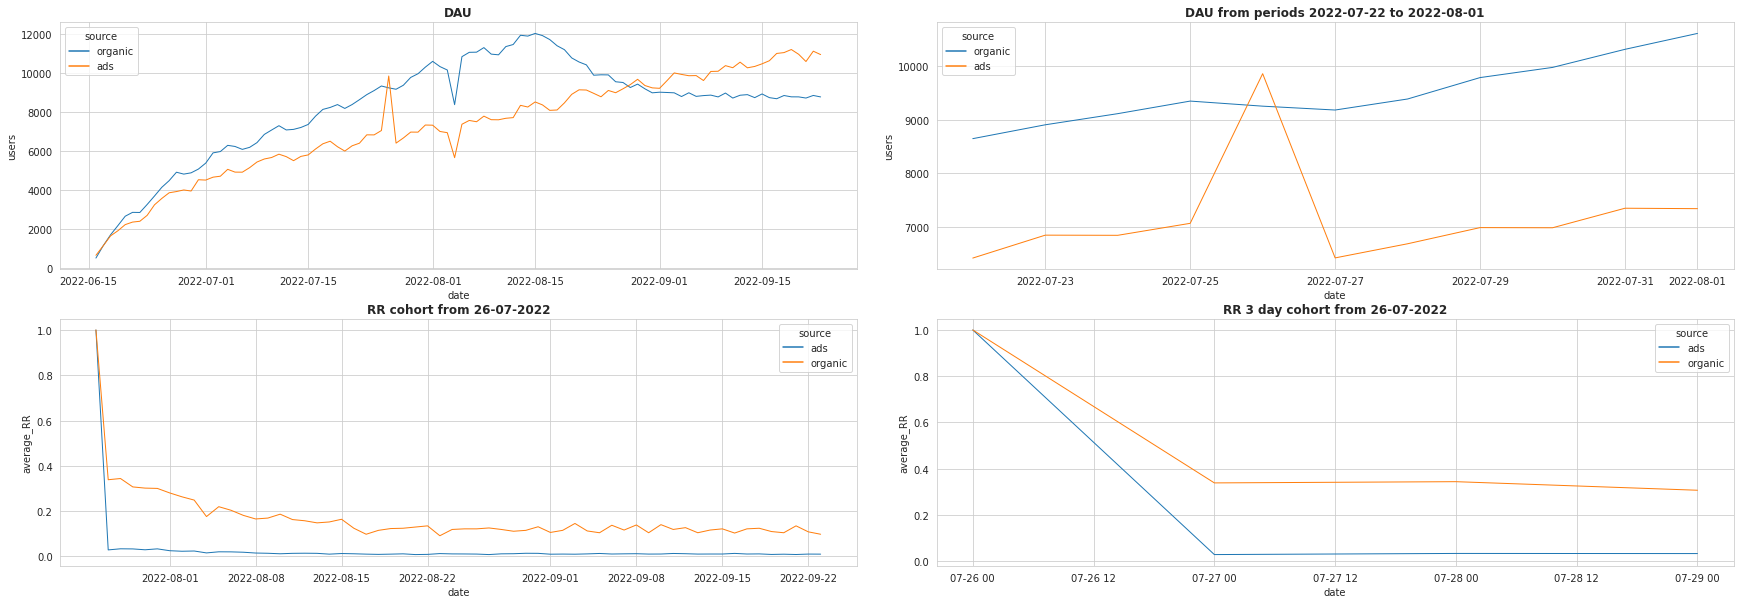

In [25]:
# построение графиков DAU/WAU/MAU/Views/Likes/CTR
fig, axes = plt.subplots(2, 2,  figsize=(30,10))
# plt.rcParams['axes.facecolor'] = 'white'
fig.subplots_adjust(hspace=0.2)  # развинем графики
fig.subplots_adjust(wspace=0.1)
# ГРАФИК DAU полный
sns.lineplot(ax=axes[0, 0], data=dau_ads, x='date', y='users', hue='source',palette="tab10", linewidth=1)
axes[0, 0].set_title('DAU', fontsize=12, fontweight="bold")
# ГРАФИК только рекламных пользователей ads + не весь период а 5 дней до и 5 дней после рекламной компании
sns.lineplot(ax=axes[0, 1], data=dau_ads.query('date >= "2022-07-22" & date <= "2022-08-01"'), x='date', y='users', hue='source',palette="tab10", linewidth=1)
axes[0, 1].set_title('DAU from periods 2022-07-22 to 2022-08-01', fontsize=12, fontweight="bold")
# ГРАФИК Retantion Rate когорт 
sns.lineplot(ax=axes[1, 0], data=rr, x='date', y='average_RR', hue='source', palette="tab10", linewidth=1)
axes[1, 0].set_title('RR cohort from 26-07-2022', fontsize=12, fontweight="bold")
# ГРАФИК Retantion Rate 3-го дня когорт за 26.07.2022
sns.lineplot(ax=axes[1, 1], data=rr_3_days, x='date', y='average_RR', hue='source', palette="tab10", linewidth=1)
axes[1, 1].set_title('RR 3 day cohort from 26-07-2022', fontsize=12, fontweight="bold")

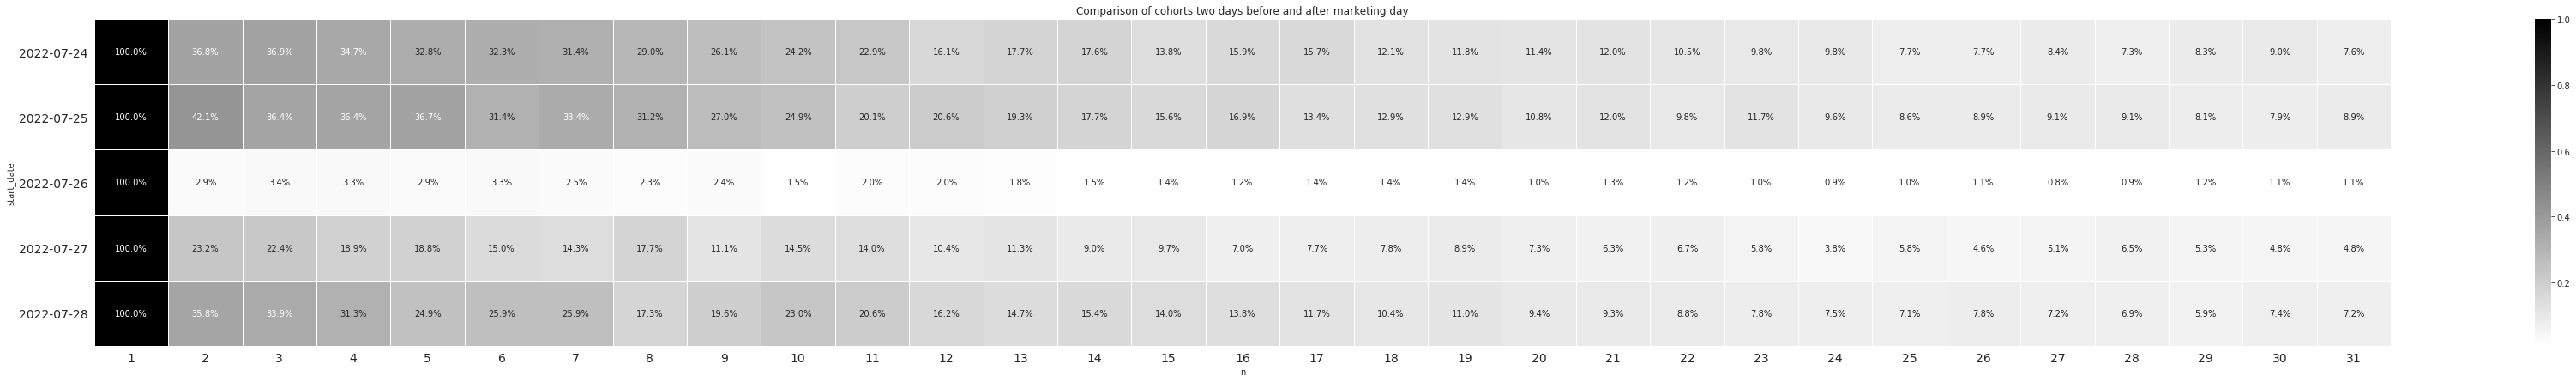

In [26]:
# строим хитмэп без нулевого лайфтайма
df = pd.pivot_table(rr_hm,
               index = 'start_date',
               columns = 'n',
               values = 'AVG(percent)').iloc[0:,0:31]
fig, axes = plt.subplots(1, 1,  figsize=(60,7))
sns.heatmap(df,
            linewidths=.5,
            cmap='binary',
            annot=True,  # включаем подписи
            fmt='.1%')
plt.title('Comparison of cohorts two days before and after marketing day') # название графика
# sns.set(font_scale=1)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0,  fontsize=14)
plt.show()

В результате проведенной рекламной компании 26.07.2022 на графиках заметен значительный скачок количества уникальных пользователей ads присоединившихся к приложению, при этом пользователи ads пришедшие 26.07.2022 показывают очень низкий коэффициент удержания, по состоянию на 31 день 1%, тогда как пользователи за день до и после рекламной компании имели RR в несколько раз больше (не менее 4%), так же отношение ads пользователей к органическим падает после проведения рекламной компании, это все говорит нам о том, что трафик был не качественным, возможно маркетологи использовали новую рекламмную компанию, которая оказалась очень плохой.

## Анализ падения активной аудитории

Мы наблюдаем внезапное падение активной аудитории 2022-08-04!

Определим, какие пользователи не смогли зайти в приложение, что их объединяет.

In [27]:
#расчет DAU
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY 
         toStartOfDay(toDateTime(time))
'''
dau = select(sql)
print('вид таблицы DAU:')
display(dau.head())

вид таблицы DAU:


,date,num_users
0,2022-08-14,20187
1,2022-08-20,19717
2,2022-08-30,18585
3,2022-08-23,18882
4,2022-09-17,19722


In [28]:
#расчет DAU по трафику
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
                source,  
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY source,
         toStartOfDay(toDateTime(time))
ORDER BY source
'''
dau_traffic = select(sql)
print('вид таблицы DAU в зависимости от трафика:')
display(dau_traffic.head())

вид таблицы DAU в зависимости от трафика:


,date,source,num_users
0,2022-06-23,ads,2719
1,2022-06-24,ads,3259
2,2022-09-06,ads,9887
3,2022-08-27,ads,9209
4,2022-08-18,ads,8123


In [29]:
#расчет DAU по ОС
sql = '''SELECT toStartOfDay(toDateTime(time)) AS date,
                os,  
                 count(DISTINCT user_id) AS num_users
FROM simulator_20220820.feed_actions
GROUP BY os,
         toStartOfDay(toDateTime(time))
ORDER BY os
'''
dau_os = select(sql)
print('вид таблицы DAU в зависимости от операционной системы:')
display(dau_os.head())

вид таблицы DAU в зависимости от операционной системы:


,date,os,num_users
0,2022-07-07,Android,7303
1,2022-09-02,Android,12152
2,2022-09-14,Android,12424
3,2022-08-17,Android,12821
4,2022-07-28,Android,10348


In [30]:
#расчет DAU по стране
sql = '''SELECT *, sum(num_users) OVER (PARTITION BY country) as sum
FROM 
    (SELECT toStartOfDay(toDateTime(time)) AS date,
                    country,  
                     count(DISTINCT user_id) AS num_users
    FROM simulator_20220820.feed_actions
    GROUP BY country,
             toStartOfDay(toDateTime(time))
    ORDER BY country) as tabl
    ORDER BY sum DESC
'''
dau_country = select(sql)
print('вид таблицы DAU в зависимости от страны:')
display(dau_country.head())

вид таблицы DAU в зависимости от страны:


,date,country,num_users,sum
0,2022-07-11,Russia,11578,1357820
1,2022-07-17,Russia,12693,1357820
2,2022-07-03,Russia,9426,1357820
3,2022-06-16,Russia,1058,1357820
4,2022-07-30,Russia,14834,1357820


Text(0.5, 1.0, 'DAU on country')

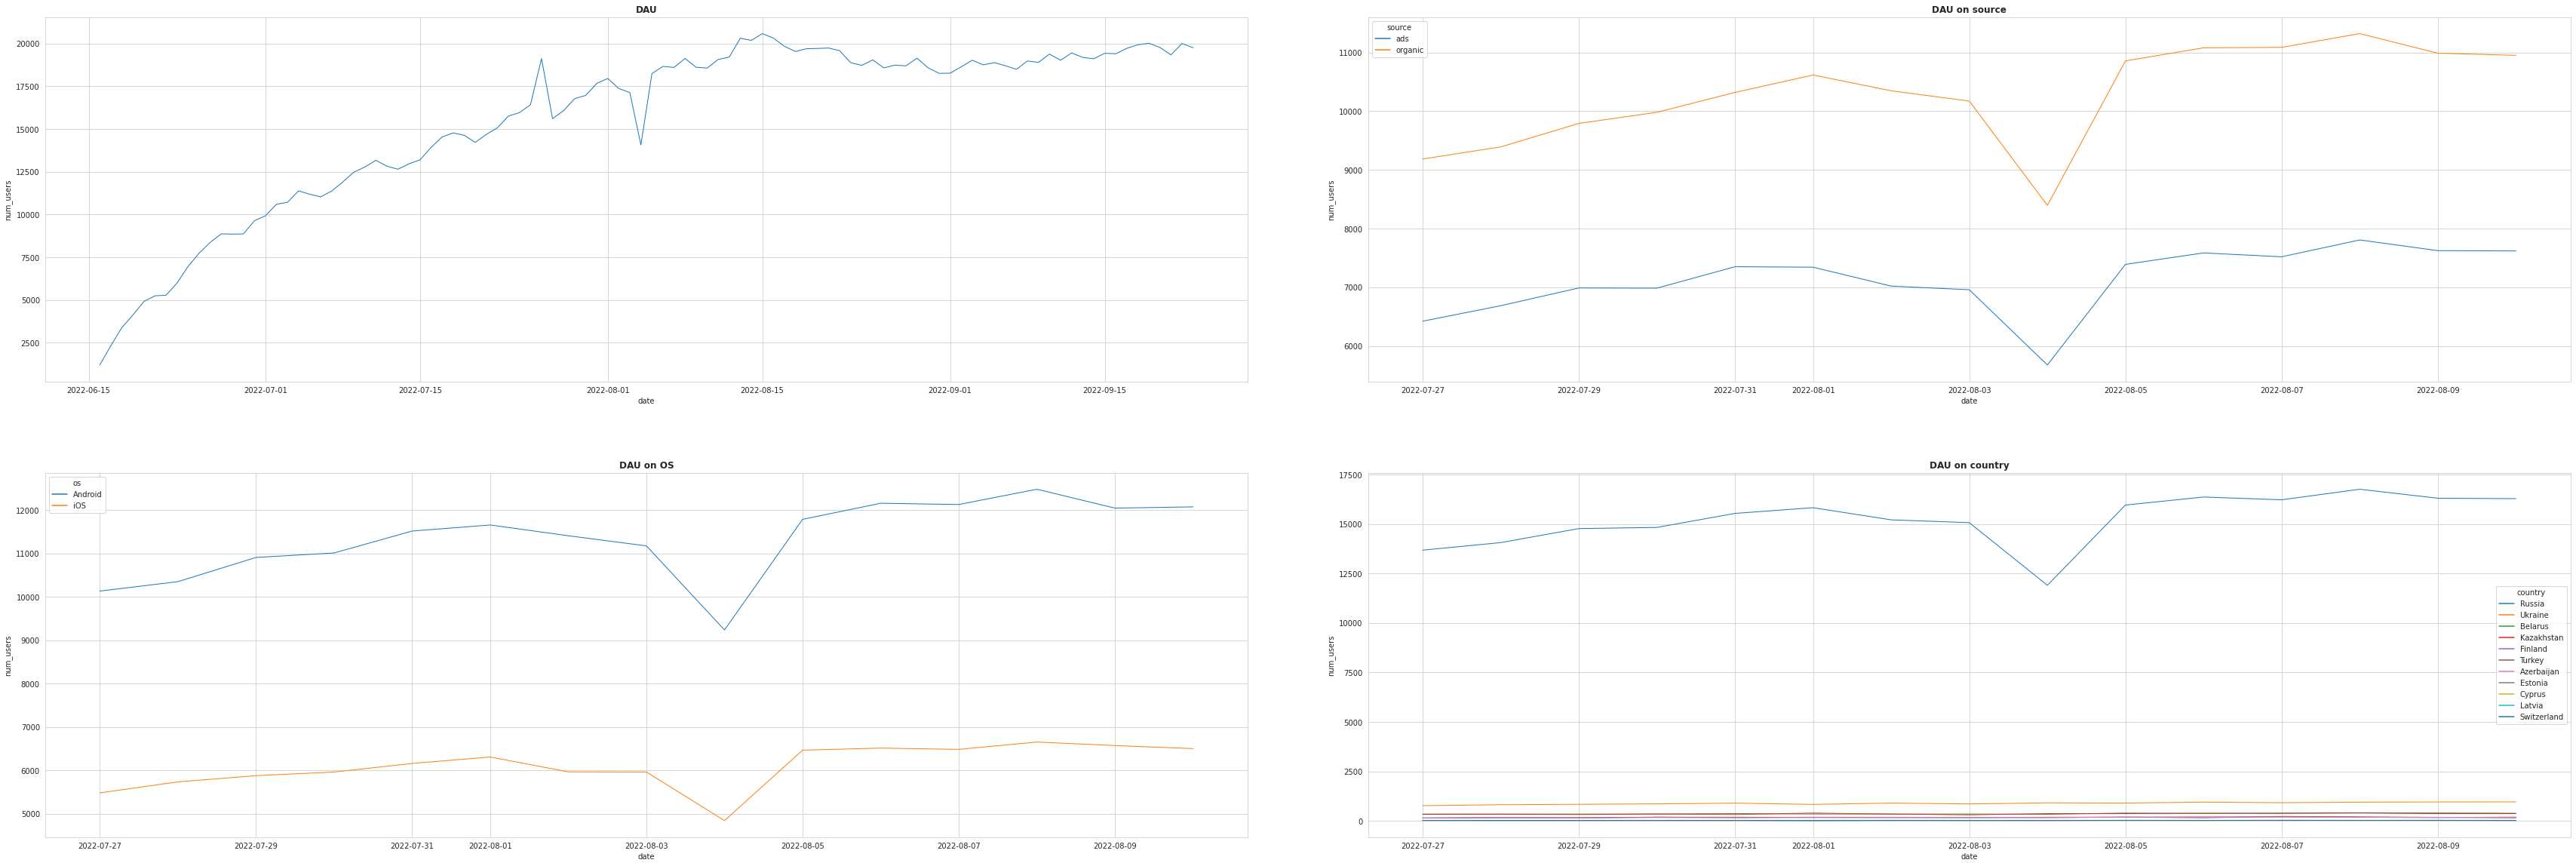

In [31]:
# построение графиков 
fig, axes = plt.subplots(2, 2,  figsize=(60,20))
# sns.set(font_scale=1)
# plt.rcParams['axes.facecolor'] = 'white'
fig.subplots_adjust(hspace=0.25)  # развинем графики
fig.subplots_adjust(wspace=0.1)
# ГРАФИК DAU полный
sns.lineplot(ax=axes[0, 0], data=dau, x='date', y='num_users', palette="tab10", linewidth=1)
axes[0, 0].set_title('DAU', fontsize=12, fontweight="bold")
# ГРАФИК Пользователи в зависимости от трафика
sns.lineplot(ax=axes[0, 1], data=dau_traffic.query('date >= "2022-07-27" & date <= "2022-08-10"'), x='date', y='num_users', hue='source',palette="tab10", linewidth=1)
axes[0, 1].set_title('DAU on source', fontsize=12, fontweight="bold")
# ГРАФИК Пользователи в зависимости операционной системы
sns.lineplot(ax=axes[1, 0], data=dau_os.query('date >= "2022-07-27" & date <= "2022-08-10"'), x='date', y='num_users', hue='os',palette="tab10", linewidth=1)
axes[1, 0].set_title('DAU on OS', fontsize=12, fontweight="bold")
# ГРАФИК Пользователи в зависимости от страны
sns.lineplot(ax=axes[1, 1], data=dau_country.query('date >= "2022-07-27" & date <= "2022-08-10"'), x='date', y='num_users', hue='country',palette="tab10", linewidth=1)
axes[1,1].set_title('DAU on country', fontsize=12, fontweight="bold")

In [32]:
sql = '''SELECT  city, 
             users as day_0, 
             CASE WHEN number =  1 THEN 0 ELSE day_1 END as day_1,
             round(day_1 *1.0 / day_0, 4) as share
     FROM
             (SELECT *,  LAST_VALUE(users) OVER (PARTITION BY city ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as day_1,
                             COUNT(users) OVER (PARTITION BY city ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as number
                            FROM
                                 (SELECT toDate(time) as date, city, count(distinct user_id) as users
                                  FROM simulator_20220820.feed_actions
                                  WHERE toDate(time) IN ('2022-08-3', '2022-08-4') 
                                  GROUP BY toDate(time), city) as tabl) as table_2
     WHERE date = '2022-08-3'
     ORDER BY day_0 DESC
'''
# sql = '''SELECT city AS city,
#        day_0 AS day_0,
#        day_1 AS day_1,
#        diff AS diff
# FROM
#   (SELECT city,
#           uniqIf(user_id, toDate(time) = '2022-08-3') as day_0,
#           uniqIf(user_id, toDate(time) = '2022-08-4') as day_1,
#           day_0-day_1 as diff
#    FROM simulator_20220820.feed_actions
#    where toDate(time) in ('2022-08-3',
#                           '2022-08-4')
#    group by city
#    order by diff DESC) AS virtual_table'''
# select(sql)
df =  select(sql) 
df.columns = ['city','day_before','day_X','share']
df.head()

,city,day_before,day_X,share
0,Moscow,2319,0,0.0000
1,Saint Petersburg,764,0,0.0000
2,Novosibirsk,213,0,0.0000
3,Yekaterinburg,210,0,0.0000
4,Chelyabinsk,195,155,0.7949


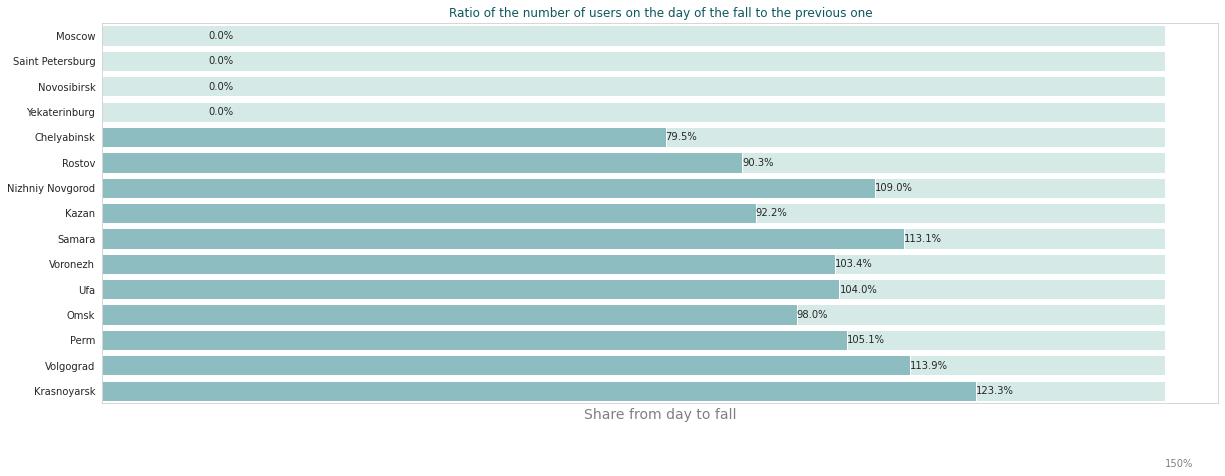

In [33]:
plt.figure(figsize=(20,7))
n=15 # какое количество городов берем так как их много, берем с наибольшим коилчеством пользователей
row = round(1+round((0.5-(df.head(n)['share'].max()-1)),2)+df.head(n)['share'].max()%1,1) # округляем до .5 если более макс значение более 100
sns.barplot(y='city', x=[row]*n, data=df.head(n), orient='h', color='#D1EEEA')
sns.barplot(y='city', x='share', data=df.head(n), orient='h', color='#85C4C9')

plt.xlabel('Share from day to fall', color='#808080', size=14)
plt.ylabel('')
plt.xticks([])
plt.title('Ratio of the number of users on the day of the fall to the previous one', color='#0D585F')

for x,y in zip(df.head(n)['share'], range(len(df.head(n)))):
    label = '{:.1%}'.format(x)
    if x == 0:
        x=0.15
    plt.annotate(label, # текст метки
                 (x,y), # координаты метки
                 textcoords="offset points", # позиция текста метки
                 xytext=(0,0), # расстояние между текстом и точкой координат метки
                 va='center') # выравнивание метки

plt.annotate(str(int(row*100))+'%', (row,n+2), annotation_clip=False, color='#808080')
plt.show()

Анализ падения количества пользователей приходится на 2022-08-04.
В  этот день произошло резкое падение активной аудитории, что видно на графиках, всех пользователей объеденяет странна пользователя, так как во всех страннах кроме России отсутсвует падение аудитории, самые крупные города имею наибольшый и макимальный спад аудитории (Москва, Санк-Петербург, Новосибирск, Екатеренбург)

## Недельная активная аудитория

Для общего понимания взаимодествия пользователей с новостной лентой отобразим активную аудиторию по неделям, для каждой недели выделим три типа пользователей.

На графиках в супперсете используется разделение пользователей:
- Новые — первая активность в ленте была на этой неделе.
- Старые — активность была и на этой и на прошлой неделе.
- Ушедшие — активность была на прошлой неделе, на этой не было.

### Вариант №1
Разделение пользователей:
- Новые — первая активность в ленте была на этой неделе.
- Старые — активность была на этой и на прошлой неделе или две недели назад.
- Ушедшие — активность не была на прошлой неделе и две недели назад, и на этой не было.

In [34]:
sql = ''' -- получаем перечень уникальных юзеров с 1 неделей события, последней неделей события, 
          -- и неделей когда пользователь перестал пользоваться сервисом
          with first_last_weeks as 
                                  (SELECT user_id, toMonday(min(time)) as start_week, toMonday(max(time)) as last_week
                                  FROM simulator_20220820.feed_actions
                                  GROUP BY user_id
                                  ORDER BY user_id),
                                  
            -- получаем список юзеров с неделями когда было совершено хоть 1 событие                      
            tabl_2 as
                     (SELECT user_id, toMonday(time) as week
                     FROM simulator_20220820.feed_actions
                     GROUP BY user_id, toMonday(time)),
            
            -- получаем список юзеров с неделями когда было совершено хоть 1 событие 
            -- + неделя 1 го события + неделя последнего события + неделя когда он перестал пользоваться сервисом
            
            table as (SELECT*, (CASE WHEN week = start_week THEN 'NEW' 
                    WHEN addWeeks(week,-1) = previous_1_weeks OR addWeeks(week,-2) = previous_2_weeks THEN 'RETURNED'
                    ELSE 'GONE' END) as status
            FROM 
                (SELECT user_id
                       , week
                       , start_week
                           --, last_week
                       , addWeeks(week,-1) as must_previous_1_week_2 
                       , addWeeks(week,-2) as must_previous_2_weeks_2 
                           --, CASE WHEN week = start_week THEN 'NEW'  ELSE '1' END
                       , first_value(week) OVER (PARTITION BY user_id ORDER BY week ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) AS previous_1_weeks 
                       , first_value(week) OVER (PARTITION BY user_id ORDER BY week ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS previous_2_weeks 
                FROM tabl_2 
                LEFT JOIN first_last_weeks ON tabl_2.user_id = first_last_weeks.user_id
                ORDER BY user_id, week) as t1)
                
           SELECT week
           , countIf(distinct user_id,status='NEW') as new_users
           , countIf(distinct user_id,status='RETURNED') as returned_users
           , - countIf(distinct user_id,status='GONE') as gone_users
           FROM table
           GROUP BY week           
   '''
df = select(sql)  
df.columns = ['week', 'new','retained','gone']
df['week'] =df['week'].dt.date
df

,week,new,retained,gone
0,2022-06-13,6881,0,0
1,2022-06-20,12989,6577,0
2,2022-06-27,13537,17361,0
3,2022-07-04,14126,25506,-709
4,2022-07-11,14097,31077,-2951
5,2022-07-18,14186,35757,-5977
6,2022-07-25,17060,40323,-8981
7,2022-08-01,13327,43886,-11903
8,2022-08-08,13613,47844,-15909
9,2022-08-15,10328,52209,-18389


Text(0.5, 1.0, 'Weekly audience')

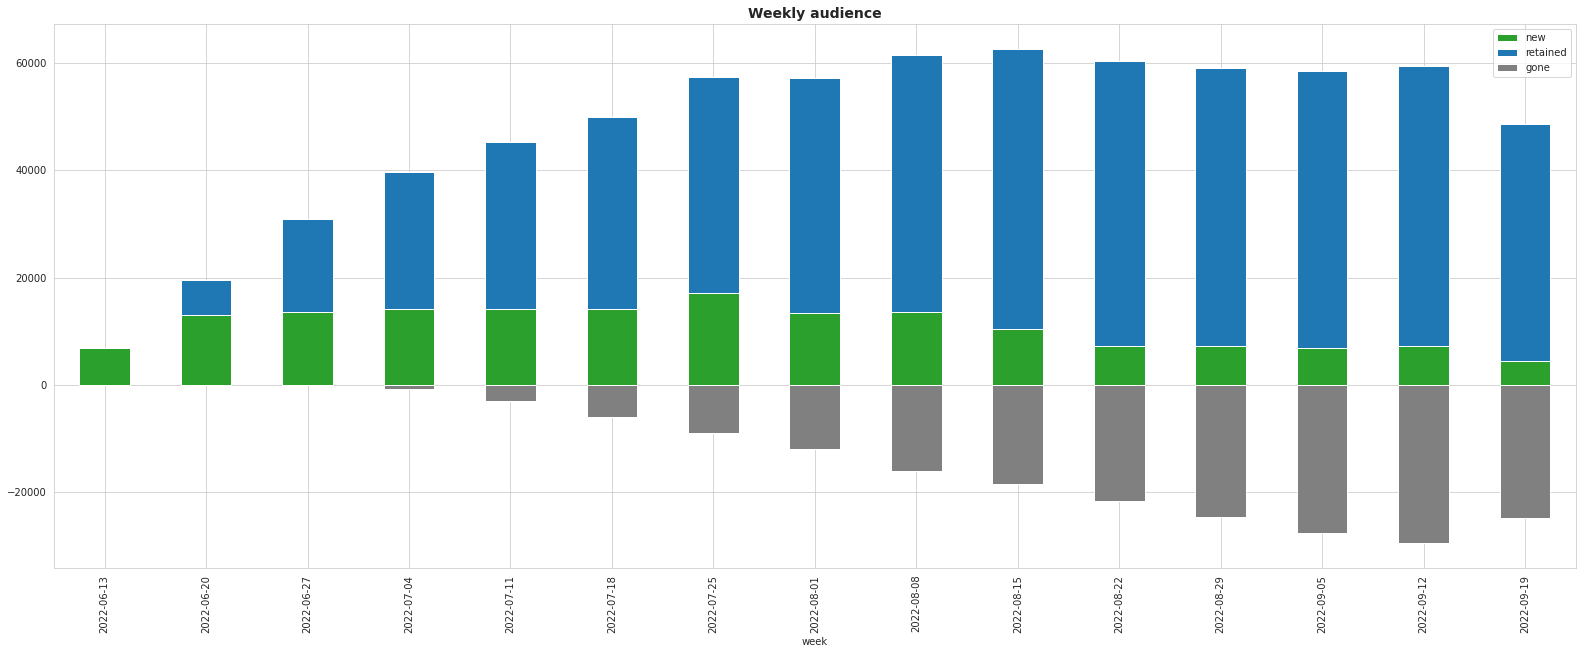

In [35]:
fig = plt.figure(figsize=(60, 10))
sns.color_palette("light:#5A9", as_cmap=True)
ax = fig.add_subplot(121)

df.set_index('week').plot(kind='bar', color=['tab:green','tab:blue','grey'] , stacked=True,  ax=ax) 
ax.set_title('Weekly audience', fontsize=14, fontweight="bold")

### Вариант №2
Разделение пользователей:
- Новые — первая активность в ленте была на этой неделе.
- Старые — активность была и на этой и на прошлой неделе.
- Ушедшие — активность была на прошлой неделе, на этой не было.

In [36]:
sql = ''' SELECT this_week, 
      previous_week, 
      status, 
      -count(distinct user_id) as num_users
FROM 
    (SELECT user_id, 
          groupUniqArray(toMonday(toDate(time))) as weeks_visited,
          addWeeks(arrayJoin(weeks_visited),+1) as this_week, 
          if(has(weeks_visited,this_week)=1,'retained', 'gone') as status, 
          addWeeks(this_week, -1) as previous_week
    from simulator_20220820.feed_actions
    GROUP BY user_id )
where status='gone'
group by this_week, previous_week, status
having this_week != addWeeks(toMonday(today()),+1)

'''
t = select(sql)
display(t.head())

,this_week,previous_week,status,num_users
0,2022-09-05,2022-08-29,gone,-32735
1,2022-09-19,2022-09-12,gone,-45276
2,2022-08-29,2022-08-22,gone,-31163
3,2022-09-12,2022-09-05,gone,-34389
4,2022-06-27,2022-06-20,gone,-2446


In [37]:
sql = '''SELECT this_week,
                previous_week,
                status,
                toInt64(count(distinct user_id)) as num_users

            FROM 
                (SELECT user_id, 
                       groupUniqArray(toMonday(toDate(time))) as weeks_visited,
                       arrayJoin(weeks_visited) as this_week, 
                       if(has(weeks_visited,addWeeks(this_week,-1))=1,'retained', 'new') as status, 
                       addWeeks(this_week, -1) as previous_week
                from simulator_20220820.feed_actions
                GROUP BY user_id) 
            GROUP BY this_week, previous_week, status
'''
t2 = select(sql)
display(t2.head())

,this_week,previous_week,status,num_users
0,2022-09-05,2022-08-29,retained,50889
1,2022-09-19,2022-09-12,retained,43563
2,2022-07-04,2022-06-27,new,15710
3,2022-08-22,2022-08-15,new,29906
4,2022-09-12,2022-09-05,new,37240


In [38]:
df = pd.concat([t,t2]).sort_values('this_week').reset_index(drop=True)
df = df.pivot_table(index='this_week', columns='status', values='num_users').reset_index()
df = df[['this_week', 'new','retained','gone']]
df['this_week'] = df['this_week'].dt.date
df.columns = ['week', 'new','retained','gone']
df = df.fillna(0)
display(df.head())

,week,new,retained,gone
0,2022-06-13,6881.0,0.0,0.0
1,2022-06-20,12989.0,6577.0,-304.0
2,2022-06-27,13778.0,17120.0,-2446.0
3,2022-07-04,15710.0,24631.0,-6267.0
4,2022-07-11,18074.0,30051.0,-10290.0


Text(0.5, 1.0, 'Weekly audience')

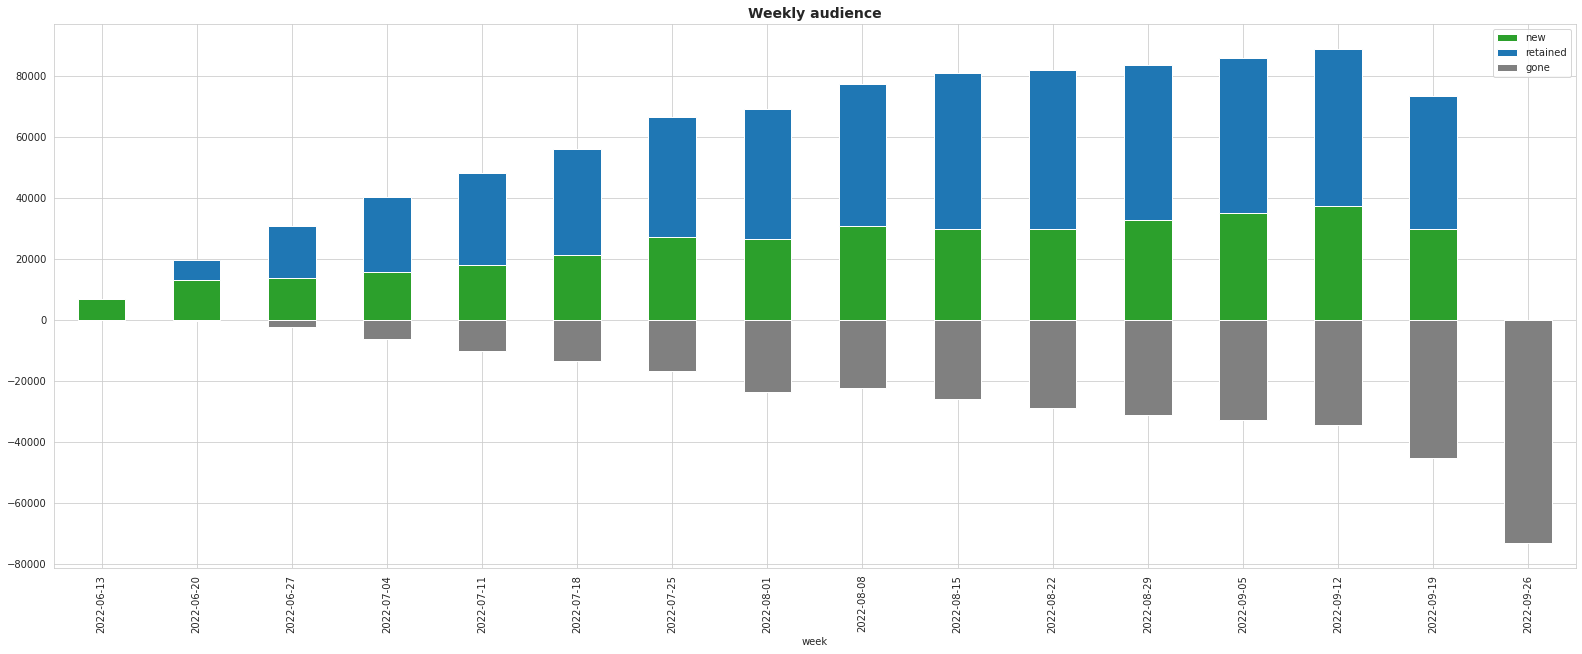

In [39]:
fig = plt.figure(figsize=(60, 10))
sns.color_palette("light:#5A9", as_cmap=True)
ax = fig.add_subplot(121)

df.set_index('week').plot(kind='bar', color=['tab:green','tab:blue','grey'] , stacked=True,  ax=ax)
ax.set_title('Weekly audience', fontsize=14, fontweight="bold")

# АА-тест

Мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, у нас есть данные **АА-теста с '2022-07-06' по '2022-07-12'**. Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации мы будем формировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы и после проведем сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.


In [40]:
# выгрузим данные
sql = '''SELECT user_id, 
       exp_group,
       countIf(action,action='view') as view,
       countIf(action,action='like') as like,
       like/view as ctr
FROM simulator_20220820.feed_actions
where toDate(time) between '2022-07-06' and '2022-07-12'
and exp_group in (2,3) --только 
group by user_id, exp_group
'''
df = select(sql)
display(df.head())

,user_id,exp_group,view,like,ctr
0,115383,3,36,11,0.305556
1,123580,3,92,15,0.163043
2,131473,2,148,26,0.175676
3,23985,2,66,12,0.181818
4,24523,2,120,17,0.141667


In [41]:
number_of_sample = 10000 # Количество выборок
s=500 # размер выборки
p_val_arr = [] # пустой список

for _ in range(0, number_of_sample):  
    sam_1 = df[df.exp_group == 2]['ctr'].sample(s, replace= True) # выборка ctr из гурппы 2
    sam_2 = df[df.exp_group == 3]['ctr'].sample(s, replace= True)  # выборка ctr из гурппы 3
    p = stats.ttest_ind(sam_1,
                    sam_2,
                    equal_var=False) # ttest по сделанным воборкам
    p_val_arr.append(p[1])

<AxesSubplot:ylabel='Count'>

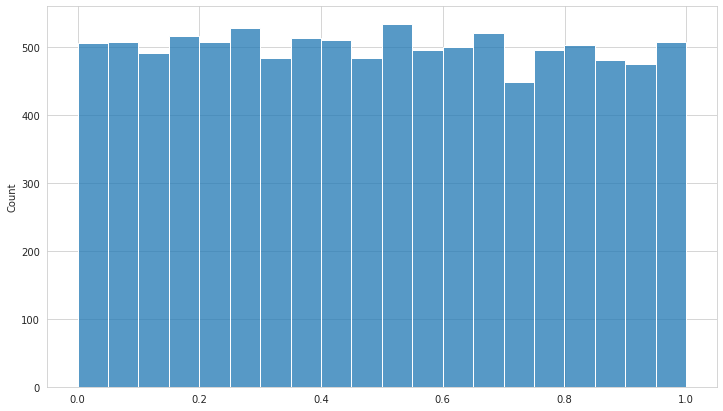

In [42]:
fig = plt.figure(figsize=(12, 7))
sns.histplot(p_val_arr, bins=20) # строим гистогармму с 20 столбцами для удобства рассмотрения(1 столбец 5%) 

In [43]:
# проверим наличие одних и тех же пользователей в разных гурппах
print('Количество пользователей одновременно находящихся в разных тестовых групах: {}'.format(len(df.groupby('user_id').agg({'exp_group':'nunique'}).query('exp_group >1'))))

Количество пользователей одновременно находящихся в разных тестовых групах: 0


In [44]:
# проверим что бы количество пользователей было одинаково
print('Количество пользователей в {}'.format(df.groupby('exp_group')['user_id'].count()))

Количество пользователей в exp_group
2    8480
3    8569
Name: user_id, dtype: int64


In [45]:
dff = pd.DataFrame(data=p_val_arr,columns={'p_values'}) # создадим дф из списка полученых п-значений
dff['col'] = dff['p_values'].apply(lambda x: True if x <= 0.05 else False) # укажем True если меньше или равно 0,05, я остальным False
print('Процент значений p-values, которые оказались меньше чем заданная alpha = 5% всего {:.3%}'.format(dff.col.sum()/len(df)))

Процент значений p-values, которые оказались меньше чем заданная alpha = 5% всего 2.962%


**ВЫВОДЫ:**

Если бы у нас был процент "больших" p-value больше 5% - это бы не значило, что сплитование некорректно. Тут нам как раз правильно смотреть на совокупность: равномерность распределение - небольшая доля маленьких pvalue, соответсвенно делаем вывод, что система сплитования работает корректно, распределение пользователей равномерно, а p-значение соответсвует заданной alpha.

# Анализ A/B теста
Мы провели вместе с командой дата сайентистов АВ-эксперименты, которые используют новые алгоритмы рекомендаций . 

- дата эксперимента с 2022-07-13 по 2022-07-19 включительно
- группа №1 - контрольная
- группа №2 - тестовая, в которой использовался один из новых алгоритмов рекомендации постов

**Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.**

In [46]:
# выгрузим данные
sql = '''
SELECT exp_group,
       user_id, 
       countIf(action='view') as view,
       countIf(action='like') as like,
       like/view as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) BETWEEN '2022-07-13' AND '2022-07-19' 
AND exp_group IN (1,2) 
GROUP BY exp_group, user_id
'''
df = select(sql)
display(df.head())

,exp_group,user_id,view,like,ctr
0,1,109963,15,3,0.200000
1,1,26117,141,32,0.226950
2,1,138232,73,18,0.246575
3,1,26295,122,33,0.270492
4,1,18392,32,7,0.218750


Проверим наличие одних и тех же пользователей в разных гурппах

In [47]:
print('Количество пользователей одновременно находящихся в разных тестовых групах: {}'.format(len(df.groupby('user_id').agg({'exp_group':'nunique'}).query('exp_group >1'))))

Количество пользователей одновременно находящихся в разных тестовых групах: 0


Проверим, что бы количество пользователей было одинаково

In [48]:
print('Количество пользователей в {}'.format(df.groupby('exp_group')['user_id'].count()))

Количество пользователей в exp_group
1    10079
2     9952
Name: user_id, dtype: int64


Проверим, что бы юзеры совершали события каждый день во время прохождения теста и не было пропущенных значений

In [49]:
sql = '''
select exp_group,
        toDate(time) as dt, 
       countIf(action,action='view') as view,
       countIf(action,action='like') as like,
       count(distinct user_id) as num_users
from simulator_20220820.feed_actions
where toDate(time) between '2022-07-13' and '2022-07-19' 
and exp_group in (1,2) 
group by exp_group, toDate(time)
order by dt, exp_group
'''

In [50]:
print('''Эксперимент проводился 7 дней
Пользователи совершали действия в течении:
{} дней - группа №1
{} дней - группа №2
'''.format(select(sql).query('exp_group == 1')['dt'].nunique(),
           select(sql).query('exp_group == 2')['dt'].nunique()))

Эксперимент проводился 7 дней
Пользователи совершали действия в течении:
7 дней - группа №1
7 дней - группа №2



Данные присутствуют за каждый день периода проведения теста

Посмотрим на распределение по группам

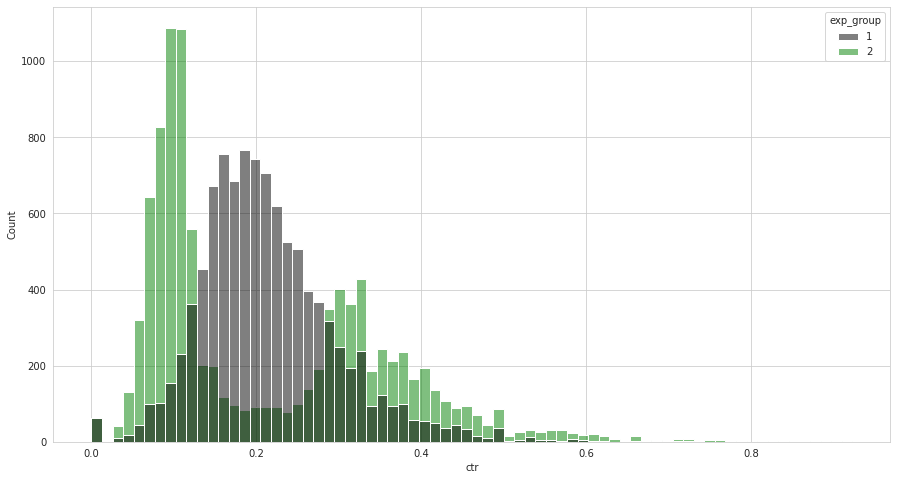

In [51]:
fig, axes = plt.subplots(1, 1,  figsize=(15,8))
groups = sns.histplot(data=df,
                     x='ctr',
                     hue='exp_group',
                     palette =['black','g'],
                     alpha = 0.5,
                     kde=False)

In [52]:
df.groupby('exp_group').agg({'ctr':'mean'})

,ctr
exp_group,
1,0.215605
2,0.214419


По графику можно сказать, что различая есть так как графики имеют разное распределение, так у 2 группы две моды, и большое количество значений находится слева от среднего значения, а так же есть аномальные значения у двух групп, при этом средние значения приблизительно равны, на что могли повлиять как раз выбросы.

Зададим alpha = 0.05

In [53]:
alpha = 0.05

## T-тест

In [54]:
p_value = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)[1]
print('P-value =',p_value)
if p_value < alpha:
    print("Статистическая значимость разницы средних значений CTR групп 1 и 2 ЕСТЬ")
else:     
    print("Статистическая значимость разницы средних значений CTR групп 1 и 2 НЕТ")

P-value = 0.4780623130874935
Статистическая значимость разницы средних значений CTR групп 1 и 2 НЕТ


Большое начение P-value полученное в Т-тест говорит нам о том, что нет оснований пологать что средние значения CTR разные, но выше мы уже увидили разное распределение значений одна из которых вообще не нормально, а значит Т-тест мог быть ошибочным из-за ненормального распределения.

## Тест Манна - Уитни

In [55]:
p_value = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                alternative='two-sided')[1]
print('P-value =',p_value)
if p_value < alpha:
    print("Статистическая значимость CTR между группами 1 и 2 ЕСТЬ")
else:     
    print("Статистической значимости CTR между группами 1 и 2 НЕТ")

P-value = 6.0376484617779035e-56
Статистическая значимость CTR между группами 1 и 2 ЕСТЬ


Очень маленькое значение P-value полученное в тесте Манна - Уитни говорит нам о том, что есть статистически значимое различае между CTR.

## Сглаживание Лапласа

In [56]:
# функция сглаживания 
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [57]:
global_ctr_1 = df[df.exp_group == 1].like.sum()/df[df.exp_group == 1].view.sum()
global_ctr_2 = df[df.exp_group == 2].like.sum()/df[df.exp_group == 2].view.sum()

In [58]:
gr1 = df[df.exp_group == 1].copy()
gr2 = df[df.exp_group == 2].copy()

In [59]:
gr1['smothed_ctr'] = df.apply(
    lambda x:get_smothed_ctr(x['like'], x['view'], 
    global_ctr_1, 5), axis=1)

gr2['smothed_ctr'] = df.apply(
    lambda x:get_smothed_ctr(x['like'], x['view'], 
    global_ctr_2, 5), axis=1)

Text(0.5, 1.0, 'Не зглаженные графики распределения')

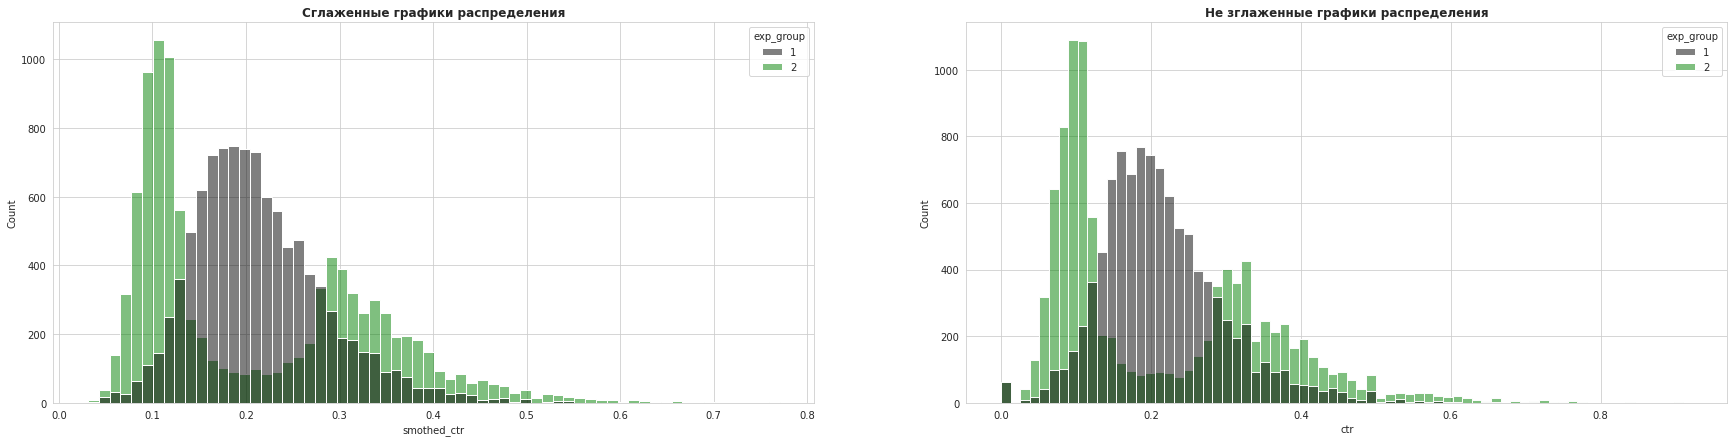

In [60]:
# посомотрим на сглаженные графики распределения
fig, axes = plt.subplots(1, 2,  figsize=(30,7))
groups = sns.histplot(data=pd.concat([gr1,gr2]),
                     x='smothed_ctr',
                     hue='exp_group',
                     palette =['black','g'],
                     alpha = 0.5,
                     kde=False,
                     ax=axes[0])
axes[0].set_title('Cглаженные графики распределения', fontsize=12, fontweight="bold")
groups = sns.histplot(data=df,
                     x='ctr',
                     hue='exp_group',
                     palette =['black','g'],
                     alpha = 0.5,
                     kde=False,
                     ax=axes[1])
axes[1].set_title('Не зглаженные графики распределения', fontsize=12, fontweight="bold")

## T-тест на сглаженном ctr  (сглаживание Лапласа)

In [61]:
# проведем ttest для сглаженых CTR
p_value = stats.ttest_ind(gr1.smothed_ctr,
                gr2.smothed_ctr,
                equal_var=False)[1]
print('P-value =',p_value)
if p_value < alpha:
    print("Статистическая значимость CTR между группами 1 и 2 ЕСТЬ")
else:     
    print("Статистической значимости CTR между группами 1 и 2 НЕТ")

P-value = 0.0223769815558559
Статистическая значимость CTR между группами 1 и 2 ЕСТЬ


## Тест Манна - Уитни на сглаженном ctr (сглаживание Лапласа)

In [62]:
# проведем Манна - Уитни для сглаженых CTR
p_value = stats.mannwhitneyu(gr1.smothed_ctr,
                gr2.smothed_ctr,
                alternative = 'two-sided')[1]
print('P-value =',p_value)
if p_value < alpha:
    print("Статистическая значимость CTR между группами 1 и 2 ЕСТЬ")
else:     
    print("Статистической значимости CTR между группами 1 и 2 НЕТ")

P-value = 1.6163964114270227e-61
Статистическая значимость CTR между группами 1 и 2 ЕСТЬ


Результат т-теста уже на сглаженом CTR показывает другой результат, т.е. есть основание пологать, что CTR отличается в двух группах, а тест Манна - Уитни так же говорит о статистически значимых различиях значений CTR, но при этом идея сглаженного CTR не дает теоретической гарантии, что его направленность совпадает с направленностью общего количества кликов(Для кого-то это основная причина такое НЕ использовать).

## Пуассоновский бутстреп

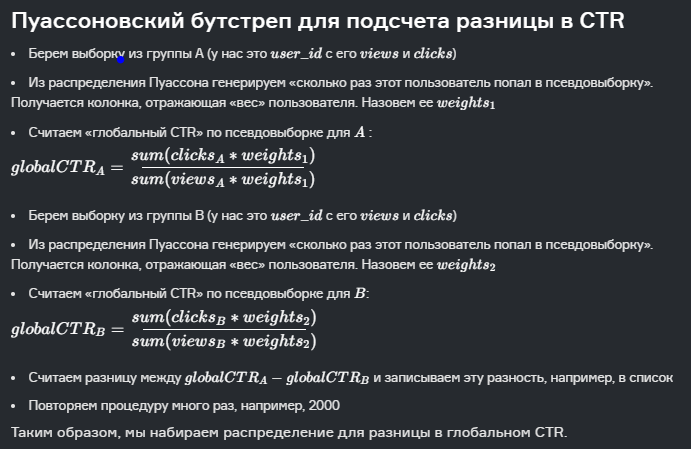

In [63]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=5000):
    # генерируем веса для групп
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [64]:
likes1= gr1.like.to_numpy() # likes1= df[df.exp_group == 1].like.to_numpy()
views1= gr1.view.to_numpy() # views1= df[df.exp_group == 1].view.to_numpy()
likes2= gr2.like.to_numpy() # likes2= df[df.exp_group == 2].like.to_numpy()
views2= gr2.view.to_numpy() # views2= df[df.exp_group == 2].view.to_numpy()

In [65]:
ctr1,ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

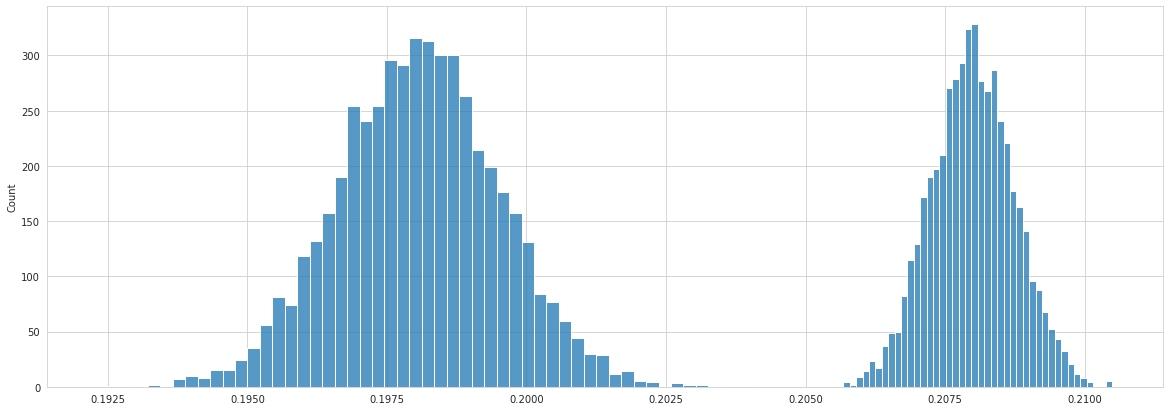

In [66]:
# Гистограммы групповых CTR
fig, axes = plt.subplots(1, 1 , figsize=(20,7))
sns.histplot(ctr1)
sns.histplot(ctr2)

Из рапределение видно, что графики расположены далеко друг от друга и не пересекаются, что говорит нам о том, что глобальный CTR разный в двух группах

<AxesSubplot:ylabel='Count'>

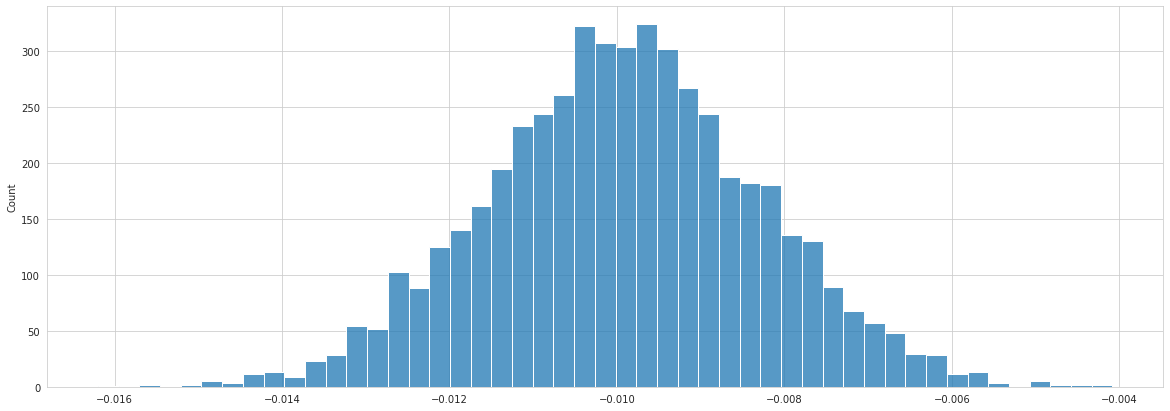

In [67]:
# посмотрим на распределение разницы между глобальными CTR
fig, axes = plt.subplots(1, 1 , figsize=(20,7))
sns.histplot(ctr2 - ctr1)

На графике распределения разницы между глобальным CTR тестовой группы 2 и контрольной группой 1 видно, что значение отрицательны, а значит, CTR в тестовой группе 2 меньше чем в контрольной, т.е. алгоритм рекомендации постов не повысил CTR текстовой группы, т.е. если мы провдем тест, то получи P-value = 0

## T-тест (Пуассоновский бутстреп)

In [68]:
p_value = stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)[1]
print('P-value =',p_value)
if p_value < 0.05:
    print("Статистическая значимость CTR между группами 1 и 2 ЕСТЬ")
else:     
    print("Статистической значимости CTR между группами 1 и 2 НЕТ")

P-value = 0.0
Статистическая значимость CTR между группами 1 и 2 ЕСТЬ


## Тест Манна - Уитни (Пуассоновский бутстреп)

In [69]:
p_value = stats.ttest_ind(ctr1,
                ctr2,
                equal_var=False)[1]
print('P-value =',p_value)
if p_value < 0.05:
    print("Статистическая значимость CTR между группами 1 и 2 ЕСТЬ")
else:     
    print("Статистической значимости CTR между группами 1 и 2 НЕТ")

P-value = 0.0
Статистическая значимость CTR между группами 1 и 2 ЕСТЬ


Как и предполагалось, значение P нулевое.

## Бакетное преобразование

### Бакетное преобразование (средствами clickhouse)

In [70]:
sql= '''
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM simulator_20220820.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
'''
df1 = select(sql)
display(df1.head())

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


### средствами clickhouse (средствами clickhouse)

In [71]:
sql= '''
SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM simulator_20220820.feed_actions 
WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id
'''
df2 = select(sql)
display(df2.head())

,exp_group,bucket,user_id,likes,views,ctr
0,2,36,140393,10,36,0.277778
1,2,20,15527,22,63,0.349206
2,1,11,124935,7,50,0.140000
3,2,1,2063,4,9,0.444444
4,2,23,126632,16,32,0.500000


In [72]:
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [73]:
df2 = df2.groupby(['exp_group','bucket']).agg({'views':'sum','likes':'sum'}).reset_index().sort_values('bucket') # группируем данные по номеру теста и корзине
df2['bucket_ctr'] = df2.likes /df2.views # считаем Ctr по корзине
display(df2.head())

,exp_group,bucket,views,likes,bucket_ctr
0,1,0,13355,2624,0.196481
50,2,0,13559,2634,0.194262
1,1,1,12653,2681,0.211887
51,2,1,12474,2686,0.215328
2,1,2,14767,3046,0.206271


Text(0.5, 1.0, 'Группа №2')

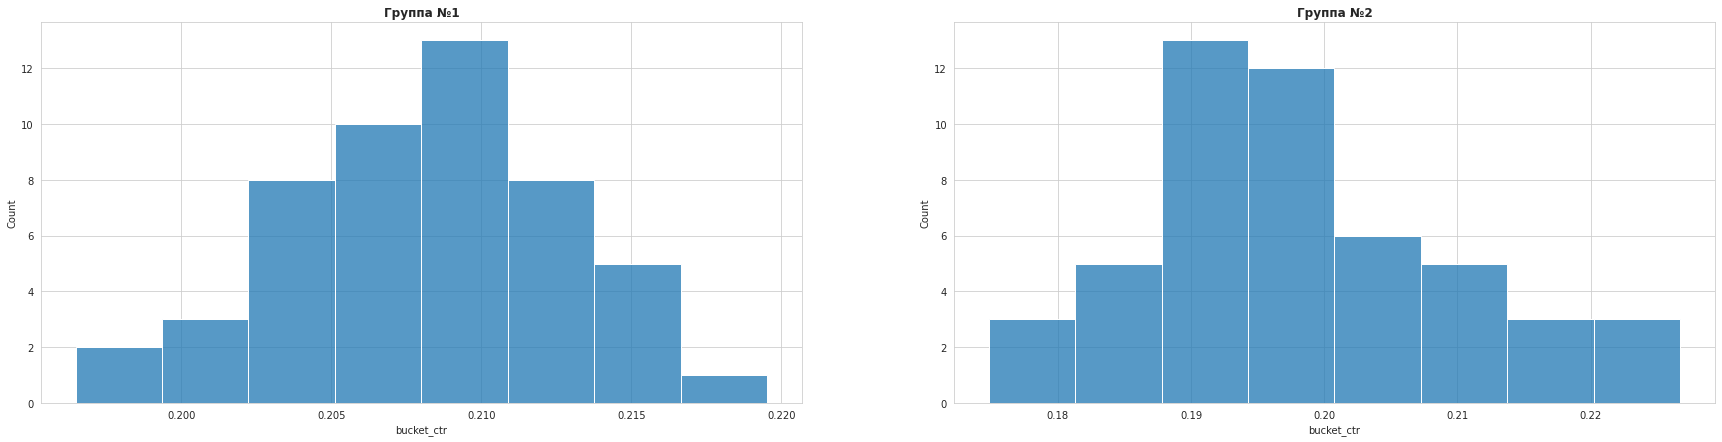

In [74]:
fig, axes = plt.subplots(1, 2,  figsize=(30,7))
sns.histplot(df1[df1.exp_group == 1].bucket_ctr, ax=axes[0])
axes[0].set_title("Группа №1", fontsize=12, fontweight="bold")
sns.histplot(df1[df1.exp_group == 2].bucket_ctr, ax=axes[1])
axes[1].set_title("Группа №2", fontsize=12, fontweight="bold")

По графикам видно, что для первой группы более приблеженно к нормальному, тогда как для группы 2 видно скошенность влево, т.е. в сторону уменьшения

## T-тест поверх бакетного преобразования

In [75]:
# по данным полученным в clickhouse
stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr,
                   df1[df1.exp_group == 2].bucket_ctr,
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [76]:
# по данным полученным в python использована функция хэширвоания с солью
stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr,
                   df2[df2.exp_group == 2].bucket_ctr,
                   equal_var = False)

Ttest_indResult(statistic=5.668234732054008, pvalue=3.4455951649941936e-07)

## Тест Манна - Уитни поверх бакетного преобразования

In [77]:
# по данным полученным в clickhouse
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr,
                   df1[df1.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [78]:
# по данным полученным в python использована функция хэширвоания с солью
stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr,
                   df2[df2.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Как мы видим P-value тестов поверх бакетного преоброзования видит различаи в значения CTR

## Метод анализа тестов над метриками-отношениями вида 𝑥/𝑦

Идея метода заключается в следующем:
Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост.

- Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

In [79]:
# выгрузим данные
sql = '''
select exp_group,
       user_id, 
       countIf(action='view') as view,
       countIf(action='like') as like
       ,like/view as ctr
from simulator_20220820.feed_actions 
where toDate(time) between '2022-07-13' and '2022-07-19' 
and exp_group in (0,1,2,3)
group by exp_group,user_id
'''
df = select(sql)
display(df.head())

,exp_group,user_id,view,like,ctr
0,3,115383,30,9,0.300000
1,1,18392,32,7,0.218750
2,3,123580,48,13,0.270833
3,2,131473,134,14,0.104478
4,2,32420,128,26,0.203125


Посчитаем общий CTR в контрольных группах  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

In [80]:
tab = df.groupby('exp_group').agg({'view':'sum','like':'sum'}).reset_index().sort_values('exp_group')
CTRcontrol_0 = tab.iloc[0,2]/tab.iloc[0,1]
CTRcontrol_1 = tab.iloc[1,2]/tab.iloc[1,1]
print('''Общий CTR для группы:
№0 - {}
№1 - {}'''.format(CTRcontrol_0,CTRcontrol_1))

Общий CTR для группы:
№0 - 0.20823612262916305
№1 - 0.20802680490126244


Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [81]:
df['linearized_likes'] = df.apply(lambda x: 
                                  x['like'] - CTRcontrol_0 * x['view'] 
                                  if x['exp_group'] == 0 or x['exp_group'] == 3 
                                  else x['like'] - CTRcontrol_1 * x['view'], axis=1)
display(df.head())

,exp_group,user_id,view,like,ctr,linearized_likes
0,3,115383,30,9,0.300000,2.752916
1,1,18392,32,7,0.218750,0.343142
2,3,123580,48,13,0.270833,3.004666
3,2,131473,134,14,0.104478,-13.875592
4,2,32420,128,26,0.203125,-0.627431


In [82]:
# Cравним  t-тестом отличия в группах по метрике linearized_likes
# Для этого напишем функцию
def tttest(df, gr1, gr2, col,col2, alpha):
    p_value_1 = stats.ttest_ind(df[df.exp_group == gr1][col],
                df[df.exp_group == gr2][col],
                equal_var=False)[1]
    p_value_2 = stats.ttest_ind(df[df.exp_group == gr1][col2],
                df[df.exp_group == gr2][col2],
                equal_var=False)[1]
    return print('P-value для поюзерного CTR = {}\nP-value по метрике linearized_likes = {}\nlinearized_likes < поюзерного CTR : {} ' .format(p_value_1,p_value_2, p_value_1>p_value_2))

### Проанализируем тест между группами 0 и 3 по метрике линеаризованных лайков. Определим видно ли отличие и Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше

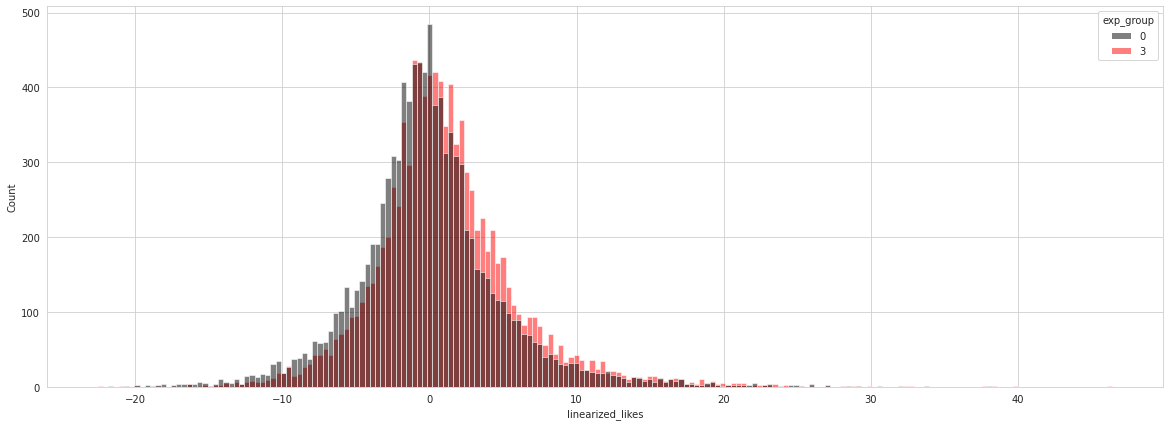

In [83]:
# Построим графики распределения
fig, axes = plt.subplots(1, 1 , figsize=(20,7))
groups = sns.histplot(data=df.query('exp_group in (0,3)'),
                     x='linearized_likes',
                     hue='exp_group',
                     palette =['black','r'],
                     alpha = 0.5,
                     kde=False)

In [84]:
tttest(df,0,3,'ctr','linearized_likes', 0.05)

P-value для поюзерного CTR = 1.055849414662529e-43
P-value по метрике linearized_likes = 5.4914249479690016e-52
linearized_likes < поюзерного CTR : True 


**Между P-values поюзерного CTR и linearized_likes есть разница, а именно значение P_value стало меньше**

### Проанализируем тест между группами 1 и 2 по метрике линеаризованных лайков. Определим видно ли отличие и Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше

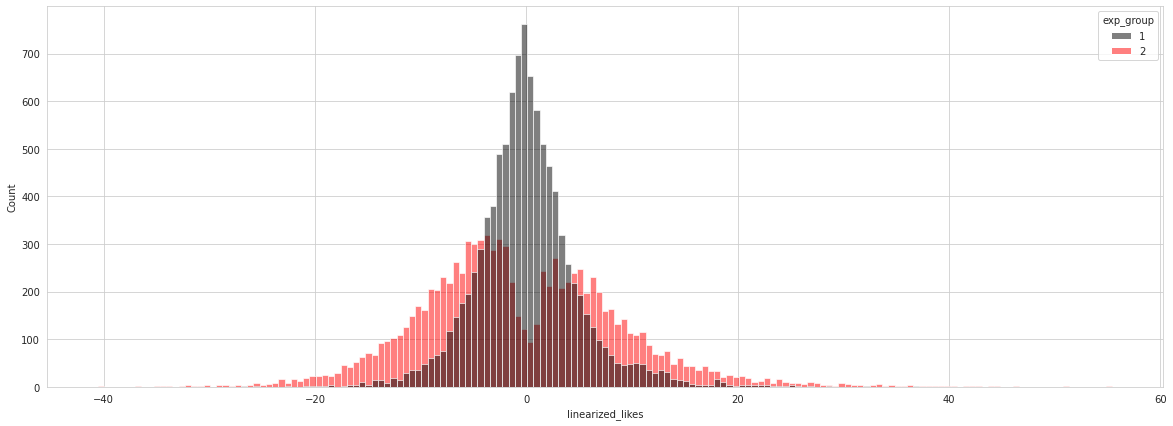

In [85]:
fig, axes = plt.subplots(1, 1 , figsize=(20,7))
groups = sns.histplot(data=df.query('exp_group in (1,2)'),
                     x='linearized_likes',
                     hue='exp_group',
                     palette =['black','r'],
                     alpha = 0.5,
                     kde=False)

In [86]:
tttest(df,1,2,'ctr','linearized_likes', 0.05)

P-value для поюзерного CTR = 0.4780623130874935
P-value по метрике linearized_likes = 9.439432187037644e-10
linearized_likes < поюзерного CTR : True 


**Между P-values поюзерного CTR и linearized_likes есть разница, а именно значение P_value стало меньше**

**ВЫВОДЫ:**

1. **T-тест** – p-value полученное имеет значение больше чем alpha=0.05, что не позволяет нам отвергнуть гипотезу о равенстве средних CTR, при этом на графике распределения отчетливо видно два совершенно разных распределения:
Группа 1 более похожа на нормальное распределение, имеются небольшие выбросы, с 1 модой, большая часть значений распределена вокруг среднего;
группа 2 имеет ненормальное распределение 2 моды, 1 смещена в меньшую сторону от среднего (что может говорить об уменьшении CTR), а вторая в большую (что может говорить об увеличении CTR), к тому же есть значительное количество аномальных значений, которые возможно и выровняли значения средних CTR. 
Возможно из-за того, что распределение ненормальное параметрический тест ошибочно определяет равенство средних.
2. **Тест Манна – Уитни** – результат, полученный в данном тесте дает основания нам полагать, что есть статистически значимое различая между CTR.
3. **T-тест на сглаженном ctr** – результат этого теста уже противоречит первому, т.е. говорит нам разнице средних CTR двух групп.
4. **Тест Манна - Уитни на сглаженном ctr** - так же как и первый тест этим методом, говорит о статистически значимых различиях значений CTR.
5. **Пуассоновский бутстреп** – графики, полученные в результате данного метода, не пересекаются, а разница глобальных CTR находится левее нуля, т.е. отрицательные, а значит CTR тестовой группы меньше чем у контрольной. 
6. **T-тест и Тест Манна-Уитни поверх бакетного преобразования** – видят, что есть статистически значимое различие между CTR двух групп.
7. **Линеаризация повысила чувствительность метрики** и позволило в свою очередь отвергнуть нулевую гипотезу о равенстве средних CTR.


**ЗАКЛЮЧЕНИЕ:**

На основании проведённых тестов, принимаем решение об не успешности теста и соответственно раскатывать новый алгоритм на всех новых пользователей не стоит,
но так как график показал нам 2 моды, можем стоит провести еще один тест, при этом увеличить размер выборки.


## ПОСТРОЕНИЕ ETL-ПАЙПЛАЙНА

Организуем вариант ETL задачу которая будет, организована в airflowm, в результате чего ежедневно за вчерашний день будет собираться информация в табилцу:
- В feed_actions для каждого юзера посчитаем число просмотров и лайков контента.
- В message_actions для каждого юзера считаем, сколько он получает и отсылает сообщений, скольким людям он пишет, сколько людей пишут ему.

**DAG для airflow**:

In [87]:
from datetime import datetime, timedelta
import pandas as pd
from io import StringIO
import requests
import pandahouse

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context

# пишем Функцию для CH
def ch_get_df(query='Select 1', host='https://clickhouse.lab.karpov.courses', user='student', password='dpo_python_2020'):
    r = requests.post(host, data=query.encode("utf-8"), auth=(user, password), verify=False)
    result = pd.read_csv(StringIO(r.text), sep='\t')
    return result

connection = {
   'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220820.feed_actions'
}
#df = pandahouse.read_clickhouse(q, connection=connection)
connection_test = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'test',
                      'user':'student-rw', 
                      'password':'656e2b0c9c' 
                     }

# Дефолтные параметры, которые прокидываются в таски
default_args = {
    'owner': 'a-mershevoj-10', 
    'depends_on_past': False,  
    'retries':5,
    'retry_delay': timedelta(minutes=3),
    'start_date': datetime(2022, 8, 31),
}
#owner - создатель
#retries - число перезапусков
#retry_delay - промежуток между повторными запусками 
#start_date - начало с какого числа считать

# Интервал запуска DAG (Cron-выражение)
schedule_interval = '0 11 * * *'

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)

def mershik_dag():
    @task() # получаем список всех изеров когда либо своршивших хоть одно целевое действия с их age, gender и os
    def extract_unique_users():
        sql_1 = '''
                SELECT   uniq_users.user_id as user_id
                       ,  case when feed_users.os not in ('iOS','Android') THEN  msg_users.os ELSE  feed_users.os END  as OS
                       ,  case when feed_users.os not in ('iOS','Android') THEN  msg_users.gender ELSE  feed_users.gender END  as gender
                       ,  case when feed_users.os not in ('iOS','Android') THEN  msg_users.age ELSE  feed_users.age END  as age
                 FROM  
                                    (SELECT user_id
                                    FROM simulator_20220820.message_actions
                                    --WHERE toDate(time) = '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                                    UNION DISTINCT 
                                    SELECT reciever_id
                                    FROM simulator_20220820.message_actions
                                    -- WHERE toDate(time) =  '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                                    UNION DISTINCT 
                                    SELECT user_id
                                    FROM simulator_20220820.feed_actions  
                                    -- WHERE toDate(time) =  '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                                    ) as uniq_users
                LEFT JOIN
                                    (SELECT distinct user_id, gender, age, os
                                    FROM simulator_20220820.feed_actions
                                    -- WHERE toDate(time) =  '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                                    ) as feed_users
                on feed_users.user_id = uniq_users.user_id
                LEFT JOIN 
                                    (SELECT distinct user_id, gender, age, os
                                    FROM simulator_20220820.message_actions
                                    -- WHERE toDate(time) =  '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                                    ) as msg_users
                on msg_users.user_id = uniq_users.user_id
                '''
        uniq_users = pandahouse.read_clickhouse(sql_1, connection=connection)
        return uniq_users

    @task() # для каждого юзера получаем число лайков и просмотров за вчера --today() - 1
    def extract_feed(uniq_users): 
        sql_2 = '''
                            SELECT  toDate(time) as event_date, 
                                    user_id,
                                    countIf(action='view') as views,
                                    countIf(action='like') as likes
                            FROM simulator_20220820.feed_actions
                            WHERE toDate(time) = '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                            GROUP BY toDate(time), user_id
                            '''
        views_likes = pandahouse.read_clickhouse(sql_2, connection=connection)
        views_likes = uniq_users.merge(views_likes, on = 'user_id',how='inner')
        views_likes = views_likes.assign(**{'messages_sent': 0, 'users_sent': 0, 'messages_received': 0, 'users_received': 0})
        return views_likes

    @task() # для каждого юзера получаем число отправленых и полученых сообщений, 
    # а скольким он писал или от скольктих уникальным юзеров получал письма
    def extract_message(uniq_users):
        # сколько каждый из юзеров получал сообщений и от скольких уникальным юзерам
        sql_3 = '''
                            SELECT   toDate(time) as event_date, reciever_id as user_id, 
                                              count(reciever_id) as messages_received,
                                              count(distinct user_id) as users_received
                            FROM simulator_20220820.message_actions
                            WHERE toDate(time) = '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'
                            GROUP BY  toDate(time), reciever_id
                        '''
                        # сколько каждый из юзеров отправлял сообщений и скольким уникальным юзерам
        sql_4 = '''
                            SELECT  toDate(time) as event_date, user_id,
                                  count(user_id) as messages_sent,
                                  count(distinct reciever_id) as users_sent
                            FROM simulator_20220820.message_actions
                            WHERE toDate(time) = '2022-09-17' -- BETWEEN '2022-08-20' and '2022-09-08'  
                            GROUP BY toDate(time), user_id
                        '''
        received = pandahouse.read_clickhouse(sql_3, connection=connection)
        sent = pandahouse.read_clickhouse(sql_4, connection=connection)
        df_msg = pd.concat([sent,received])
        df_msg = uniq_users.merge(df_msg, on='user_id').sort_values('event_date')
        df_msg = df_msg.assign(**{'likes': 0, 'views': 0})
        df_msg = df_msg[['user_id','OS','gender','age','event_date','views','likes','messages_sent','users_sent','messages_received','users_received']]
        # df_msg = uniq_users.merge(pd.concat([sent,received]),on=['user_id']).sort_values('event_date')
        return df_msg

    @task()
    def merge_feed_and_msg(df_msg, views_likes):
        df = pd.concat([views_likes,df_msg])
        df = df.fillna(0)
        return df

    @task()
    def transform_os(df):
        df_os= df.groupby(['event_date','OS']).sum().reset_index()
        df_os= df_os.drop(columns = ['user_id','gender','age'],axis = 1)
        df_os.insert(1, "dimension", "OS")
        df_os.rename(columns = {'OS' : 'dimension_value'}, inplace = True)
        df_os.columns = ['event_date','dimension','dimension_value','views','likes','messages_received','messages_sent','users_received','users_sent']
        return df_os

    @task()
    def transform_gender(df):
        df_gender = df.groupby(['event_date','gender']).sum().reset_index()
        df_gender = df_gender.drop(columns = ['user_id', 'age'],axis = 1)
        df_gender.insert(1, "dimension", "gender")
        df_gender.rename(columns = {'gender' : 'dimension_value'}, inplace = True)
        df_gender.columns  = ['event_date','dimension','dimension_value','views','likes','messages_received','messages_sent','users_received','users_sent']
        df_gender['dimension_value'].replace([0,1],['Female','Male'],inplace=True)
        return df_gender

    @task()
    def tranasform_age(df):
        df_age = df.groupby(['event_date','age']).sum().reset_index()
        df_age = df_age.drop(columns = ['gender','user_id'],axis = 1)
        df_age.insert(1, "dimension", "age")
        df_age.rename(columns = {'age' : 'dimension_value'}, inplace = True)
        df_age.columns  = ['event_date','dimension','dimension_value','views','likes','messages_received','messages_sent','users_received','users_sent']
        return df_age

    @task()
    def concat_tables(df_os,df_gender,df_age):
        df_final = pd.concat([df_os, df_age, df_gender]).query('dimension_value != ""')
        # df_final['dimension_value'] = df_final['dimension_value'].astype('str')
        df_final['views'] = df_final['views'].astype(int)
        df_final['likes'] = df_final['likes'].astype(int)
        df_final['messages_received'] = df_final['messages_received'].astype(int)
        df_final['messages_sent'] = df_final['messages_sent'].astype(int)
        df_final['users_received'] = df_final['users_received'].astype(int)
        df_final['users_sent'] = df_final['users_sent'].astype(int)
        # df_final['event_date']=df_final['event_date'].apply(lambda x: datetime.isoformat(x))
        df_final = df_final.reset_index(drop=True)
        return df_final

    @task()
    def load(df_final):
        # create_tabl = '''DROP TABLE test.mershik'''
        create_tabl = '''CREATE TABLE IF NOT EXISTS test.mershik
            (
            event_date DATE,
            dimension String,
            dimension_value String,
            views UInt64,
            likes UInt64,
            messages_received UInt64,
            messages_sent UInt64,
            users_received UInt64,
            users_sent UInt64
            ) ENGINE = MergeTree()
            ORDER BY (event_date);
            '''
        pandahouse.execute(query=create_tabl, connection=connection_test)
        pandahouse.to_clickhouse(df=df_final, 
                                 table='mershik', 
                                 index=False, 
                                 connection=connection_test)



    uniq_users = extract_unique_users()
    views_likes = extract_feed(uniq_users) 
    df_msg = extract_message(uniq_users) 
    df = merge_feed_and_msg(df_msg, views_likes) 
    df_os = transform_os(df) 
    df_gender = transform_gender(df) 
    df_age = tranasform_age(df)
    df_final = concat_tables(df_os, df_gender, df_age)
    load(df_final)
    
mershik_dag = mershik_dag()

## АВТОМАТИЗАЦИЯ ОТЧЕТНОСТИ

### Отчет по ленте

Автоматизируем базовую отчетность нашего приложения. 

Наладим автоматическую отправку аналитической сводки в телеграм, каждое утро в 11 часов.

Напишим скрипт для сборки отчета по ленте новостей. Отчет будет состоять из двух частей:
- текст с информацией о значениях ключевых метрик за предыдущий день
- график с значениями метрик за предыдущие 7 дней

Отобразим в отчете следующие ключевые метрики: 
- DAU 
- Просмотры
- Лайки
- CTR

**DAG для airflow:**

In [88]:
from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
import telegram
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')   
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import datetime as dt
# from read_db.CH import Getch # импорт конектора предложенным по учебе (не сработал) сделал через обычное подключения 
import pandahouse
connection = {
       'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20220820.feed_actions'}

def select(sql):
    data = pandahouse.read_clickhouse(sql, connection=connection)
    return data
# Дефолтные параметры, которые прокидываются в таски
default_args = {
        'owner': 'a-mershevoj-10', 
        'depends_on_past': False,  
        'retries': 2,
        'retry_delay': timedelta(minutes=5),
        'start_date': datetime(2022, 9, 1),}
    # время запуска
schedule_interval = '0 11 * * *'  

chat_id = -555114317 # номер нашего чата что бы работало нужно что бы группа добавила бота а пользователь начал с ним общения
my_token = '5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI' # Никому не говорить - доступ к боду, выдается когда создается бот
bot= telegram.Bot(token=my_token)
updates = bot.getUpdates()
    
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def  mershik_telegram():
    @task()
    def extract_for_yesterday():
    # ЗАПРОС НА ВЫГРУЗКУ информации о значениях ключевых метрик за предыдущий день
        sql = '''
                SELECT toDate(time) as "Event date",
                       count(DISTINCT user_id) AS "DAU",
                       countIf(action='view') as "Views",
                       countIf(action='like') as "Likes",
                       round(countIf(action='like')/countIf(action='view'),4) as "CTR"
                FROM simulator_20220820.feed_actions
                where toDate(time) = today() - 1 
                group by toDate(time) 
            '''
        for_yesterday = select(sql)
        return for_yesterday
    
    @task() 
    def extract_for_last_7_days():
    # ЗАПРОС НА ВЫГРУЗКУ информации о значениях ключевых метрик за предыдущие 7 дней
        sql = '''
                SELECT toDate(time) as "Event date",
                       count(DISTINCT user_id) AS "DAU",
                       countIf(action='view') as "Views",
                       countIf(action='like') as "Likes",
                       round(countIf(action='like')/countIf(action='view'),4) as "CTR"
                FROM simulator_20220820.feed_actions
                WHERE toDate(time) >= today() - 7 
                AND  toDate(time) < today()
                GROUP BY toDate(time) 
            '''
        for_last_7_days = select(sql)
        return for_last_7_days
    @task() 
    def send_report(for_yesterday, for_last_7_days):  
    # ПОДГОТОВКА И ОТПРАВКА ТЕКСТА c информацией о значениях ключевых метрик за предыдущий день
        msg = 'Date report: {}\nDAU: {}\nViews: {}\nLikes: {}\nCTR: {:.2%}'\
            .format(for_yesterday.iloc[0,0].strftime("%d-%B-%Y"),
                    '{0:,}'.format(for_yesterday.iloc[0,1]).replace(',', ' '),
                    '{0:,}'.format(for_yesterday.iloc[0,2]).replace(',', ' '),
                    '{0:,}'.format(for_yesterday.iloc[0,3]).replace(',', ' '),
                    for_yesterday.iloc[0,4])
        bot.sendMessage(chat_id=chat_id, text=msg)
        
            # ПОДГОТОВКА И ОТПРАВКА ТЕКСТА c информацией о значениях ключевых метрик за предыдущие 7 дней  
        for col in for_last_7_days.columns:
            if col != 'Event date':
                plt.figure(figsize = (12,6))
                sns.lineplot(data = for_last_7_days,
                             x=for_last_7_days['Event date'], 
                             y=col, 
                             color='black',
                             linewidth = 1.5,ci=None,  
                             marker='o',
                             markersize=10) 
                plt.title('Informatin about '+ col +' the last 7 days')
                plt.rcParams['axes.facecolor'] = 'white' # прозрачный фон графика
                plot_object = io.BytesIO() # создаем файловый объект
                plt.savefig(plot_object) # сохраняем файловый объект
                plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта
                plot_object.name = 'plotline.png' # даем название объекту
                plt.close() # закрываем не нужные графики
                bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка картинки
                
    for_yesterday = extract_for_yesterday()
    for_last_7_days = extract_for_last_7_days()
    send_report(for_yesterday, for_last_7_days)
    
mershik_telegram = mershik_telegram()

### Отчет по приложению

Соберем единый отчет по работе всего приложения. В отчете отразим информацию и по ленте новостей, и по сервису отправки сообщений. 

**DAG для airflow:**

In [102]:
from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
import telegram
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')   
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import datetime as dt
# from read_db.CH import Getch # импорт конектора предложенным по учебе (не сработал) сделал через обычное подключения 
import pandahouse

connection = {
       'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20220820.feed_actions'}
def select(sql):
    data = pandahouse.read_clickhouse(sql, connection=connection)
    return data

# Дефолтные параметры, которые прокидываются в таски
default_args = {
        'owner': 'a-mershevoj-10', 
        'depends_on_past': False,  
        'retries': 2,
        'retry_delay': timedelta(minutes=5),
        'start_date': datetime(2022, 9, 1),}
    # время запуска
schedule_interval = '0 11 * * *'  

chat_id = -555114317 # номер нашего чата что бы работало нужно что бы группа добавила бота а пользователь начал с ним общения
my_token = '5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI' # Никому не говорить - доступ к боду, выдается когда создается бот
bot= telegram.Bot(token=my_token)
updates = bot.getUpdates()
    
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def  mershik_telegram_task_2():
    @task()
    def extract_feed():
    # количество уникальных пользователей за последние 10 дней 
        sql='''
        SELECT  toDate(time) as date, 
                count(Distinct user_id) as "unique users", 
                countIf(action='view') as views, 
                countIf(action='like') as likes, 
                round((countIf(action='view')+countIf(action='like'))/count(Distinct user_id),4) as "Num events per user",
                round(countIf(action='like')/countIf(action='view'),4) as CTR
        FROM  simulator_20220820.feed_actions
        WHERE toDate(time) BETWEEN today()-10 and today()
        GROUP BY toDate(time)
        ORDER BY date'''
        dau_feeds =pandahouse.read_clickhouse(sql, connection=connection)
        dau_feeds['mean'] = dau_feeds.loc[0:9,'unique users'].mean()
        return dau_feeds
        
    @task()      
    def extract_feed_new():
        #количество новых пользователей 
        sql = '''WITH tab AS 
                (SELECT *, count(*) over (partition by user_id order by date ) AS cnt
                        FROM
                            (SELECT  toDate(time) as date, user_id
                            FROM  simulator_20220820.feed_actions
                            WHERE toDate(time) BETWEEN today()-10 and today()
                            GROUP BY toDate(time),user_id) as t)

                SELECT date, sum(cnt) as "new users"
                FROM tab
                WHERE cnt = 1
                AND toDate(date) BETWEEN today()-10 and today()
                GROUP BY date
                ORDER BY date
                '''
        new_feeds = pandahouse.read_clickhouse(sql, connection=connection)
        new_feeds['mean'] = new_feeds.loc[0:9,'new users'].mean()
        return new_feeds
    
    @task() 
    def extract_msg():
        # в сервисе сообщений
        sql_3='''
        SELECT  toDate(time) as  date, 
                count(Distinct user_id) as "unique users", 
                count(*) as "sent messages",
                round(count(*)/count(Distinct user_id),4)  as "Sent messages per user",
                round(count(*)/count(Distinct reciever_id),4)  as "Received messages per user"
        FROM  simulator_20220820.message_actions
        WHERE toDate(time) BETWEEN today()-10 and today()
        GROUP BY toDate(time)
        ORDER BY date'''
        dau_msg =pandahouse.read_clickhouse(sql_3, connection=connection)
        dau_msg['mean'] = dau_msg.loc[0:9,'unique users'].mean()
        return dau_msg
    
    @task()      
    def extract_msg_new():
        #количество новых пользователей 
        sql = '''
        with tab as 
        (SELECT *, count(*) over (partition by user_id order by date ) as cnt
        FROM 
            (SELECT  toDate(time) as date, user_id
            FROM  simulator_20220820.message_actions
            GROUP BY toDate(time),user_id) as t)

        SELECT date, sum(cnt) as "new users"
        FROM tab
        WHERE cnt = 1
        GROUP BY date
        HAVING date BETWEEN today()-10 and today()
        ORDER BY date
        '''
        new_msg = pandahouse.read_clickhouse(sql, connection=connection)
        new_msg['mean'] = new_msg.loc[0:9,'new users'].mean()
        return new_msg
    
    @task() 
    def send_report(dau_feeds, new_feeds, dau_msg, new_msg):
        bot.sendMessage(chat_id=chat_id, text="________________________________________")
        bot.sendMessage(chat_id=chat_id, text="REPORT FOR PERIOD {} to {}".format( str(dt.datetime.now().date()- timedelta(days=10)),str(dt.datetime.now().date()- timedelta(days=1))))
        ##############################################################################################################
        ########################################## КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ ##########################################
        print('готовлю сообщение о количестве пользователей...')
        msg = '''DAU of service (unique users/new users): 
        1. News feed 
        Today - {} / {}
        Yesterday - {} / {}   
        3 days ago - {} / {} 
        7 days ago - {} / {} 
        10 days ago - {} / {} 

        2. Message service(users sent/users received):
        Today - {} / {}
        Yesterday - {} / {}    
        3 days ago - {} / {}
        7 days ago - {} / {}
        10 days ago - {} / {}
        '''\
        .format('{0:,}'.format(dau_feeds.iloc[10,1]).replace(',', ' '),'{0:,}'.format(new_feeds.iloc[10,1]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[7,1]).replace(',', ' '),'{0:,}'.format(new_feeds.iloc[7,1]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[3,1]).replace(',', ' '),'{0:,}'.format(new_feeds.iloc[3,1]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[1,1]).replace(',', ' '),'{0:,}'.format(new_feeds.iloc[1,1]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[0,1]).replace(',', ' '),'{0:,}'.format(new_feeds.iloc[0,1]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[10,1]).replace(',', ' '),'{0:,}'.format(new_msg.iloc[10,1]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[7,1]).replace(',', ' '),'{0:,}'.format(new_msg.iloc[7,1]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[3,1]).replace(',', ' '),'{0:,}'.format(new_msg.iloc[3,1]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[1,1]).replace(',', ' '),'{0:,}'.format(new_msg.iloc[1,1]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[0,1]).replace(',', ' '),'{0:,}'.format(new_msg.iloc[0,1]).replace(',', ' '),)
        bot.sendMessage(chat_id=chat_id, text=msg)
        print('сообщение о количестве пользователей ОТПРАВЛЕНО')
        #################################################################################################################
        print('готовлю графики о количестве пользователей...')
        fig, axes = plt.subplots(2, 2,  figsize=(25,10))
        sns.set_style("whitegrid")
        # plt.rcParams['axes.facecolor'] = 'white'
        fig.subplots_adjust(hspace=0.3)  # развинем графики
        fig.subplots_adjust(wspace=0.1)
        # ГРАФИК DAU
        # новости
        sns.lineplot(ax=axes[0,0], data=dau_feeds.iloc[0:,0:], x='date', y='unique users')
        sns.lineplot(ax=axes[0,0], data=dau_feeds, x='date', y='mean')
        axes[0,0].text(dau_feeds.iloc[9,0],dau_feeds.iloc[9,-1], 'mean',rotation = 0,fontsize = 15)
        axes[0,0].set_title('DAU last 10 days (feeds)', fontsize=14, fontweight="bold")
        # сообщения
        sns.lineplot(ax=axes[0,1], data=dau_msg.iloc[0:,0:], x='date', y='unique users')
        sns.lineplot(ax=axes[0,1], data=dau_msg, x='date', y='mean')
        axes[0,1].text(dau_msg.iloc[9,0],dau_msg.iloc[9,-1], 'mean',rotation = 0,fontsize = 15)
        axes[0,1].set_title('DAU last 10 days (messages)', fontsize=14, fontweight="bold")
        # ГРАФИК НОВЫХ ПОЛЬЗОВАТЕЛЕЙ
        # новости
        sns.lineplot(ax=axes[1,0], data=new_feeds.iloc[0:,0:], x='date', y='new users')
        sns.lineplot(ax=axes[1,0], data=new_feeds, x='date', y='mean')
        axes[1,0].text(new_feeds.iloc[9,0],new_feeds.iloc[9,-1], 'mean',rotation = 0,fontsize = 15)
        axes[1,0].set_title('New users 10 days (feeds)', fontsize=14, fontweight="bold")
        # сообщения
        sns.lineplot(ax=axes[1,1], data=new_msg.iloc[0:,0:], x='date', y='new users')
        sns.lineplot(ax=axes[1,1], data=new_msg, x='date', y='mean')
        axes[1,1].text(new_msg.iloc[9,0],new_msg.iloc[9,-1], 'mean',rotation = 0,fontsize = 15)
        axes[1,1].set_title('New users last 10 days (messages)', fontsize=14, fontweight="bold")

        plot_object = io.BytesIO() # создаем файловый объект
        plt.savefig(plot_object) # сохраняем файловый объект
        plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта
        plot_object.name = 'plotline.png' # даем название объекту
        plt.close() # закрываем не нужные графики
        bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка картинки
        print('графики о количестве пользователей ОТПРАВЛЕНЫ')
        ########################################## КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ ##########################################
        ##############################################################################################################
        ##############################################################################################################
        ########################################## КОЛИЧЕСТВО СОБЫТИЙ ################################################
        print('готовлю сообщение о количестве событий...')
        msg = '''Events of service: 
        1. News feed (views/likes)
        Today - {} / {}
        Yesterday - {} / {}
        3 days ago - {} / {}
        7 days ago - {} / {}
        10 days ago - {} / {}

        2. Message service (sent messages):
        Today - {}
        Yesterday - {}    
        3 days ago - {}
        7 days ago - {}
        10 days ago - {}
        '''\
        .format('{0:,}'.format(dau_feeds.iloc[10,2]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[10,3]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[7,2]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[7,3]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[3,2]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[3,3]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[1,2]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[1,3]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[0,2]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[0,3]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[10,2]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[7,2]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[3,2]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[1,2]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[0,2]).replace(',', ' '))
        bot.sendMessage(chat_id=chat_id, text=msg)
        print('сообщение о количестве событий ОТПРАВЛЕНО')
        #################################################################################################################
        print('готовлю графики о количестве событий...')
        fig, axes = plt.subplots(1, 2,  figsize=(25,10))
        sns.set_style("whitegrid")
        # plt.rcParams['axes.facecolor'] = 'white'
        fig.subplots_adjust(hspace=0.3)  # развинем графики
        fig.subplots_adjust(wspace=0.1)

        # ГРАФИК EVENTS
        # новости
        sns.lineplot(ax=axes[0], data=dau_feeds.iloc[0:,0:], x='date', y='views')
        sns.lineplot(ax=axes[0], data=dau_feeds.iloc[0:,0:], x='date', y='likes')
        axes[0].text(dau_feeds.iloc[9,0],dau_feeds.iloc[9,2], 'views',rotation = 0,fontsize = 15)
        axes[0].text(dau_feeds.iloc[9,0],dau_feeds.iloc[9,3], 'likes',rotation = 0,fontsize = 15)
        axes[0].set_title('Likes & Views', fontsize=14, fontweight="bold")

        # сообщения
        sns.lineplot(ax=axes[1], data=dau_msg.iloc[0:,0:], x='date', y='sent messages')
        axes[1].set_title('Sent messages', fontsize=14, fontweight="bold")

        plot_object = io.BytesIO() # создаем файловый объект
        plt.savefig(plot_object) # сохраняем файловый объект
        plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта
        plot_object.name = 'plotline.png' # даем название объекту
        plt.close() # закрываем не нужные графики
        bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка картинки
        print('графики о количестве событий ОТПРАВЛЕНЫ')
        ########################################## КОЛИЧЕСТВО СОБЫТИЙ ################################################
        ##############################################################################################################
        ##############################################################################################################
        ################################################ ОСНОВНЫЕ МЕТРИКИ ############################################
        print('готовлю информацию по основным метрикам сервисов...')
        msg = '''Metrics of service: 
        1. News feed (Event per user/CTR)
        Today - {} / {}
        Yesterday - {} / {}
        3 days ago - {} / {}
        7 days ago - {} / {}
        10 days ago - {} / {}

        2. Message service (Messages per user sent/received):
        Today - {} / {}
        Yesterday - {} / {}
        3 days ago - {} / {}
        7 days ago - {} / {}
        10 days ago - {} / {}
        '''\
        .format('{0:,}'.format(dau_feeds.iloc[10,4]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[10,5]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[7,4]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[7,5]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[3,4]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[3,5]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[1,4]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[1,5]).replace(',', ' '),
                '{0:,}'.format(dau_feeds.iloc[0,4]).replace(',', ' '),'{0:,}'.format(dau_feeds.iloc[0,5]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[10,3]).replace(',', ' '),'{0:,}'.format(dau_msg.iloc[10,4]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[7,3]).replace(',', ' '),'{0:,}'.format(dau_msg.iloc[7,4]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[3,3]).replace(',', ' '),'{0:,}'.format(dau_msg.iloc[3,4]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[1,3]).replace(',', ' '),'{0:,}'.format(dau_msg.iloc[1,4]).replace(',', ' '),
                '{0:,}'.format(dau_msg.iloc[0,3]).replace(',', ' '),'{0:,}'.format(dau_msg.iloc[0,4]).replace(',', ' '))
        bot.sendMessage(chat_id=chat_id, text=msg)
        print('информация по основным метрикам сервисов ОТПРАВЛЕНА')
        ##############################################################################################################
        print('готовлю графики по основным метрикам сервисов...')

        fig, axes = plt.subplots(2, 2,  figsize=(25,15))
        sns.set_style("whitegrid")
        # plt.rcParams['axes.facecolor'] = 'white'
        fig.subplots_adjust(hspace=0.3)  # развинем графики
        fig.subplots_adjust(wspace=0.1)
        # ГРАФИК EVENTS
        # новости
        sns.lineplot(ax=axes[0,0], data=dau_feeds.iloc[0:,0:], x='date', y='CTR')
        axes[0,0].set_title('CTR (feeds Likes/Views)', fontsize=14, fontweight="bold")
        sns.lineplot(ax=axes[0,1], data=dau_feeds.iloc[0:,0:], x='date', y='Num events per user')
        axes[0,1].set_title('Events per users (feeds Likes+Views)', fontsize=14, fontweight="bold")

        # сообщения
        sns.lineplot(ax=axes[1,0], data=dau_msg.iloc[0:,0:], x='date', y='Sent messages per user')
        axes[1,0].set_title('Sent messages per users', fontsize=14, fontweight="bold")
        sns.lineplot(ax=axes[1,1], data=dau_msg.iloc[0:,0:], x='date', y='Received messages per user')
        axes[1,1].set_title('Received messages per users', fontsize=14, fontweight="bold")

        plot_object = io.BytesIO() # создаем файловый объект
        plt.savefig(plot_object) # сохраняем файловый объект
        plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта
        plot_object.name = 'plotline.png' # даем название объекту
        plt.close() # закрываем не нужные графики
        bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка картинки
        print('графики по основным метрикам сервисов ОТПРАВЛЕНЫ')
        ################################################ ОСНОВНЫЕ МЕТРИКИ ############################################
        ##############################################################################################################
        ##############################################################################################################
        ################################################ СВОДНАЯ ТАБЛИЦА #############################################
        print('готовлю сводную таблицу ...')
        df = dau_feeds.merge(dau_msg,left_on='date', right_on='date')
        df = df.drop(['mean_x', 'mean_y'], axis=1)
        df.columns = ['date','unique users feeds','views','likes','events per user','CTR','unique users messages','sent messages','sent messages per user','received messages per user']

        file_object = io.StringIO()
        df.to_csv(file_object, index=True)
        file_object.seek(0)
        file_object.name = 'report_table_{}.csv'.format(str(dt.datetime.now().date()- timedelta(days=1)))

        bot.sendDocument(chat_id=chat_id, document = file_object)
        print('сводная таблица ОТПРАВЛЕНА')
        ################################################ СВОДНАЯ ТАБЛИЦА #############################################
        ##############################################################################################################

    dau_feeds = extract_feed()
    new_feeds = extract_feed_new()
    dau_msg = extract_msg()
    new_msg = extract_msg_new()
    
    send_report(dau_feeds, new_feeds, dau_msg, new_msg)
    
mershik_telegram_task_2 = mershik_telegram_task_2()

## Cистема алертов

Напишем систему которая будет с периодичность каждые 15 минут проверять ключевые метрики, такие как активные пользователи в ленте / мессенджере, просмотры, лайки, CTR, количество отправленных сообщений. 

В случае обнаружения аномального значения, в чат должен отправиться алерт - сообщение со следующей информацией: метрика, ее значение, величина отклонения, а так же график и ссылки на дашборд/чарт в BI системе. 

### Метод определения аномалий с помощью межквартильного размаха + 3-х сигм

**DAG для airflow:**

In [ ]:
from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
import telegram
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')   
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import datetime as dt
# from read_db.CH import Getch # импорт конектора предложенным по учебе (не сработал) сделал через обычное подключения 
import pandahouse
#############################################################################################################
connection = {
       'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'database': 'simulator_20220820.feed_actions'}
# Дефолтные параметры, которые прокидываются в таски
default_args = {
        'owner': 'a-mershevoj-10', 
        'depends_on_past': False,  
        'retries': 2,
        'retry_delay': timedelta(minutes=5),
        'start_date': datetime(2022, 9, 1),}
    # время запуска
schedule_interval = '*/15 * * * *' 

chat_id = -555114317 #799366541#  номер нашего чата что бы работало нужно что бы группа добавила бота а пользователь начал с ним общения
my_token = '5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI' # Никому не говорить - доступ к боду, выдается когда создается бот
bot= telegram.Bot(token=my_token)
updates = bot.getUpdates()

def check_anomaly(df, metric, a=6, n=5):
    ''' функция предлгает алгоритм поиска аномальй в данных
    правила 3х сигм и используя межквартильный размах , где
        df - датафрейм, данные сгруппированые по нужным периодам с агрег.
    данными по ним
        metric - метрика для которой будет расчет 
    (в нашем случае их три лайки, просмторы, юзеры)
        a - коэфициент которые будет влиять на ширину интервала
        n - количество временных промежутков'''
# shift - смещаем значение, что бы исключить значение текущей 15-минутки 
# для которой мы расчитывает, т.к. может быть она аномальна и/или неполной, что может изменить значение
# rolling - скользящие значения (окно) берет n Значений до (по молчанию текущее и предудущие n-1)
    if metric not in ['users_feed','views','likes','CTR']:
        a = 4
        n = 4    
############################################################################################################# МЕТОД ОПРЕДЕЛЕНИЯ №1 - ПРАВИЛО 3-х СИГМ
    # формула: Xi>Мю.n-a*std.n и Xi<Мю.n+a*std.n где
    # Мю.n −скользящее среднее за период n
    # std.n−стандартное отклонение за период n
    # a−коэффициент, задающий количество стандартных отклонений
    m = df[metric].shift(1).rolling(n+1).mean() # скользящее среднее в формуле  Мю.n возьмем на 1 больше чем задано для других
    a=3 # коэффициент, задающий количество стандартных отклонени
    std = df[metric].shift(1).rolling(n+1).std() # скользящее стандартное отклонение в формуле std
    df['up_3_sigma'] =  m + a * std 
    df['low_3_sigma'] = m - a * std 
    df['up_3_sigma'] = df['up_3_sigma'].rolling(n,center = True, min_periods=1).mean()# для сглаживания границ (что бы они не были рванными) текущей 15-минутки будет по середине
    df['low_3_sigma'] = df['low_3_sigma'].rolling(n,center = True, min_periods=1).mean()# для сглаживания границ (что бы они не были рванными) текущей 15-минутки будет по середине
    
############################################################################################################# МЕТОД ОПРЕДЕЛЕНИЯ №2 - МЕЖКВАРТИЛЬНЫЙ РАЗМАХ
    df['q25'] = df[metric].shift(1).rolling(n).quantile(0.25) # 25 квантиль
    df['q75'] = df[metric].shift(1).rolling(n).quantile(0.75) # 75 квантиль
    df['iqr'] = df['q75'] -  df['q25'] # межквартильный размах
    df['up_mejkavartil'] = df['q75'] + a * df['iqr'] # верхняя граница от 75 квантиля + "а" квартильных размаха
    df['low_mejkavartil'] = df['q25']- a * df['iqr'] # нижняя граница от 25 квантиля + "а" квартильных размаха    
    df['up_mejkavartil'] = df['up_mejkavartil'].rolling(n,center = True, min_periods=1).mean()# для сглаживания границ (что бы они не были рванными) текущей 15-минутки будет по середине
    df['low_mejkavartil'] = df['low_mejkavartil'].rolling(n,center = True, min_periods=1).mean()# для сглаживания границ (что бы они не были рванными) текущей 15-минутки будет по середине
    
############################################################################################################# МЕТОД ОПРЕДЕЛЕНИЯ №3 - PROPHET(FACEBOOK) (ПРОРОК)   (в отдельном файле)  
# укажим условие когда считать значение аномальным т.е. is_alert
    if (df[metric].iloc[-1] < df['low_mejkavartil'].iloc[-1] and df[metric].iloc[-1] < df['low_3_sigma'].iloc[-1]) or  (df[metric].iloc[-1] > df['up_mejkavartil'].iloc[-1] and  df[metric].iloc[-1] > df['up_3_sigma'].iloc[-1]):
        is_alert = 1
    else:
        is_alert = 0
    return is_alert, df
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def  mershik_telegram_alerts():
    @task()
    def run_alerts(chat=None):
        '''система алертов'''
        chat = chat_id or 799366541
        bot= telegram.Bot(token='5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI')
        # получаем необходиму таблицу вида:
        # сгруппированные данные по
        # 1. дата события в разрезе 15-минуток 'YYYY-D-M HH:MM'
        # 2. дата события без времени 
        # 3. время события без даты в разрезе 15-минуток 'HH:MM' - 00:00, 00:15, 00:30 и т.д.
        # по этим данным получаем агрегированные данные (которые мы хотим отслеживать):
        # 1. кол-во уникальных пользователей
        # 2. количество просмотров
        # 3. количество лайков
        # все данные будут за определенные промежуток в намеш случае это
        # данные за вчершний день и меньше текущего времени округленного до 15 минут 
        # так как 15 минутка может быть не полной что может исказить результат
        # для таблицы feed_actions
        sql = ''' SELECT 
                        toStartOfFifteenMinutes(time) as ts
                      , toDate(time) as date
                      , formatDateTime(ts, '%R') as hm
                      , uniqExact(user_id) as users_feed
                      , countIf(user_id, action='view') as views
                      , countIf(user_id, action='like') as likes
                      , likes/views as CTR
                FROM simulator_20220820.feed_actions
                WHERE  (time >= today() - 1 )
                AND time < toStartOfFifteenMinutes(now())
                GROUP BY ts, date, hm
                ORDER BY ts '''
        data = pandahouse.read_clickhouse(sql, connection=connection)
        # для таблицы message_actions
        sql = ''' SELECT 
                        toStartOfFifteenMinutes(time) as ts
                      , toDate(time) as date
                      , formatDateTime(ts, '%R') as hm
                      , uniqExact(user_id) as users_msg
                      , count(user_id) as sent_msg

                FROM simulator_20220820.message_actions
                WHERE  (time >= today()- 1 )
                AND time < toStartOfFifteenMinutes(now())
                GROUP BY ts, date, hm
                ORDER BY ts '''
        data_2 = pandahouse.read_clickhouse(sql, connection=connection)
        
        
        data = data.merge(data_2, on=['ts','date','hm'], how='outer') # объеденяем два датафрейма
        chart_url = {'users_feed':'http://superset.lab.karpov.courses/r/2025',
                             'views':'http://superset.lab.karpov.courses/r/2026',
                             'likes':'http://superset.lab.karpov.courses/r/2027',
                             'CTR':'http://superset.lab.karpov.courses/r/2028',
                             'users_msg':'http://superset.lab.karpov.courses/r/2024',
                             'sent_msg':'http://superset.lab.karpov.courses/r/2023'}

        metrics_list = ['users_feed','views','likes','CTR','users_msg','sent_msg'] # создадим список названий столбцов-метрик для обращения к ним в цикле
        for metric in metrics_list:
                df = data[['ts','date','hm',metric]].copy() # копируем датафрейм
                is_alert, df = check_anomaly(df, metric) # вызываем для каждой метрики в цикле функцию расчета и опредления ошибки
                # определяем группу новости или сообщения
                group = ''
                if metric in metrics_list[4:]:
                    group = 'message'
                else:
                    group = 'feed'
                if is_alert ==1 : #or True
                    # формируем сообщение и график если пред значение от текущего отличается на 10%
                    if abs(1 - (df[metric].iloc[-1]/df[metric].iloc[-2])) > 0.1:
                        msg = 'Отклонение метрики более 10% !!! @aimershik, проверь...\nМетрику {}: в срезе {}\nТекущее значение {:.2f}\nОтклонение {:.1%}\nДашборд: {}'\
                        .format(metric, 
                                group,
                                df[metric].iloc[-1],
                                abs(1 - (df[metric].iloc[-1]/df[metric].iloc[-2])),
                                chart_url[metric])
                        # # готовим грфик
                        sns.set(rc={'figure.figsize':(16,10)}) # размер изображения
                        plt.tight_layout() 
                        ax = sns.lineplot(x=df['ts'],y=df[metric],label='metric')
                        ax = sns.lineplot(x=df['ts'],y=df['up_mejkavartil'],label='up_mejkavartil')
                        ax = sns.lineplot(x=df['ts'],y=df['low_mejkavartil'],label='low_mejkavartil')
                        ax = sns.lineplot(x=df['ts'],y=df['up_3_sigma'],label='up_3_sigma')
                        ax = sns.lineplot(x=df['ts'],y=df['low_3_sigma'],label='low_3_sigma')
                        # разрядим подписи на рафикке по оси х, сделав их частично скрытими
                        # for  ind, label in enumerate(ax.get_xticklabels()):
                        #     if ind % 2 == 0:
                        #         label.set_visible(True)
                        #     else:
                        #         label.set_visible(False)
                        ax.set(xlabel='time') # подпись оси Х
                        ax.set(ylabel=metric) # подпись оси Y
                        ax.set_title(metric)
                        ax.set(ylim=(0, None))

                        plot_object = io.BytesIO() # создаем файловый объект
                        ax.figure.savefig(plot_object) # сохраняем файловый объект
                        plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта(нужно что бы не была пустой картинка)
                        plot_object.name = '{0}.png'.format(metric) # даем название объекту
                        plt.close() # закрываем не нужные графики

                        bot.sendMessage(chat_id=chat_id, text = msg) # отправка сообщения
                        bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка графика
    run_alerts()  
mershik_telegram_alerts = mershik_telegram_alerts()


### Метод определения аномалий с помощью библиотеки prophet

**Скрипт:**

In [130]:
# python -m pip install prophet
from fbprophet import Prophet
# import Prophet
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import telegram
import numpy as np
import matplotlib.pyplot as plt
import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')   
import pandas as pd
import datetime as dt
from datetime import date, datetime, timedelta
import datetime as dt
# from read_db.CH import Getch # импорт конектора предложенным по учебе (не сработал) сделал через обычное подключения 
import pandahouse
import sys
import os
connection = {
       'host': 'https://clickhouse.lab.karpov.courses',
        'password': 'dpo_python_2020',
        'user': 'student',
        'dfbase': 'simulator_20220820.feed_actions'}

init_notebook_mode(connected = True)
chat_id = 799366541 #  номер нашего чата что бы работало нужно что бы группа добавила бота а пользователь начал с ним общения
my_token = '5599579414:AAG65E0uxgpD1NsTSqJzOTnxw4KM1WpHpQI' # Никому не говорить - доступ к боду, выдается когда создается бот
bot= telegram.Bot(token=my_token)
updates = bot.getUpdates()

sql = ''' SELECT 
                toStartOfFifteenMinutes(time) as ts
              , toDate(time) as date
              , formatDateTime(ts, '%R') as hm
              , uniqExact(user_id) as users_feed
              , countIf(user_id, action='view') as views
              , countIf(user_id, action='like') as likes
              , likes/views as CTR
        FROM simulator_20220820.feed_actions
        WHERE  (time >= today()- 25)
        AND time < toStartOfFifteenMinutes(now())
        GROUP BY ts, date, hm
        ORDER BY ts '''
dff = pandahouse.read_clickhouse(sql, connection=connection)
dff.head()
for metric in ['users_feed','views','likes','CTR']:
    predictions = 2 # последние 30 минут данных
    df = dff[['ts',metric]] # приводим dataframe к нужному формату
    df.columns = ['ds', 'y']
    train_df = df[:-predictions]  # отрезаем из обучающей выборки последние 8 точек, чтобы измерить на них качество
    # Далее создаем объект класса Prophet (все параметры модели задаются в конструкторе класса, для начала возьмем default'ные параметры), но так же добавим дневную сезоность и обучаем его.
    # С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, который содержит все исторические временные точки и еще то количество меток (сейчаc 2), для которых мы хотели построить прогноз.
    # Для того, чтобы построить прогноз вызываем у модели функцию predict и передаем в нее полученный на предыдущем шаге dataframe future.
    # В библиотеке Prophet есть встроенные средства визуализации, которые позволяют оценить результат построенной модели.
    # changepoint_prior_scale Настройка гибкости тренда Если изменения тренда являются переобученными (слишком большая гибкость) или недостаточными (недостаточная гибкость), 
                            # вы можете отрегулировать силу разреженного априорного с помощью входного аргумента changepoint_prior_scale. По умолчанию этот параметр установлен на 0,05. 
                            # Его увеличение сделает тренд более гибким
    m = Prophet(changepoint_prior_scale=0.01, daily_seasonality=True) 
    m.fit(train_df)
    future = m.make_future_dataframe(periods=predictions, freq="15 min") 
    forecast = m.predict(future)
    # m.plot(forecast) # Prophet.plot отображает прогноз.
    # m.plot_components(forecast) # отражает отдельно на графике: тренд, годовую и недельную сезонность. Если при построении модели были заданы аномальные дни/праздники, то они также будут отображаться на этом графике.

    # Оценим качество алгоритма и посчитаем MAPE для заданного нами периода для предсказания(последние 30 минут).
    # forecast - это dataframe, в котором есть вся необходимая нам информация для прогноза.
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

    # if cmp_df['y'].iloc[-1] < cmp_df['yhat_lower'].iloc[-1]  or  cmp_df['y'].iloc[-1] > cmp_df['yhat_upper'].iloc[-1]:
    #     is_alert = 1
    # else:
    #     is_alert = 0

    # построение графика
    sns.set(rc={'figure.figsize':(16,10)}) # размер изображения
    plt.tight_layout() 
    periods=4*24 # сколько периодов отражать на графике (сейчас взято последние 24 часа
    ax = sns.lineplot(x=cmp_df.tail(periods).index,y=cmp_df['y'].tail(periods),label=metric)
    ax = sns.lineplot(x=cmp_df.tail(periods).index,y=cmp_df['yhat_upper'].tail(periods),label='yhat_upper')
    ax = sns.lineplot(x=cmp_df.tail(periods).index,y=cmp_df['yhat_lower'].tail(periods),label='yhat_lower')
    plot_object = io.BytesIO() # создаем файловый объект
    ax.figure.savefig(plot_object) # сохраняем файловый объект
    plot_object.seek(0)  # перемещаем куорсор в начало файлового объекта(нужно что бы не была пустой картинка)
    plot_object.name = '{}.png'.format(metric) # даем название объекту
    plt.close() # закрываем не нужные графики

    #bot.sendMessage(chat_id=chat_id, text = 'MAPE (средняя абсолютная ошибка нашего прогноза)', np.mean(abs(cmp_df[-predictions:]['p'])))
    #bot.sendMessage(chat_id=chat_id, tfext = 'MAE (на сколько ошибается модель в абсолютных величинах)', np.mean(abs(cmp_df[-predictions:]['e'])))

    bot.sendPhoto(chat_id=chat_id, photo = plot_object) # отправка график

[2022-10-03 11:59:26,016] {forecaster.py:916} INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Initial log joint probability = -15.8575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       4190.42   0.000270538       481.434   5.925e-07       0.001      123  LS failed, Hessian reset 
      99       4190.48   3.12289e-08        370.52      0.3519      0.3519      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       4190.48   8.29515e-08       340.563      0.4143      0.4143      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
[2022-10-03 11:59:40,336] {forecaster.py:916} INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Initial log joint probability = -15.7137
    Iter      log prob        ||dx||      ||grad||       al